In [2]:
import sys
import os
import numpy as np 
import h5py
import scipy
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pandas as pd
from collections import defaultdict

sys.path.append('../../src')
from utils.evaluate_utils import get_indices, get_spatial_indices, plot_qual_comparsion, random_indices3D, calculate_k_R2_timeseries, temporal_linear_interpolation_np, velocity_through_plane, calculate_flow_profile, get_boundaries
from utils.colors import *

### Single in-vivo model evaluation

In [21]:
lr_dir = '../../data/paired_invivo'
hr_dir = '../../data/paired_invivo'
sr_dir = '../../results/in_vivo/paired_data/v3_wholeheart_25mm_40ms_transformed'

lr_filename = 'v3_wholeheart_25mm_40ms_transformed.h5'
hr_filename = 'v3_wholeheart_25mm_20ms_transformed.h5'
sr_filename = 'v3_wholeheart_25mm_40ms_transformed_20250624-0138.h5'
# lr_filename = 'v3_wholeheart_25mm_40ms.h5'
# hr_filename = 'v3_wholeheart_25mm_20ms.h5'
# sr_filename = 'v3_wholeheart_25mm_40ms_20250620-1244.h5'

eval_dir = f'../../results/in_vivo/paired_data/plots/eval_{sr_filename[:-3]}'
eval_dir_paper_plots = f'../../results/in_vivo/paired_data/plots/eval_{sr_filename[:-3]}_dataaugmen/paper_drafts'
os.makedirs(eval_dir, exist_ok=True)
os.makedirs(eval_dir_paper_plots, exist_ok=True)

with h5py.File(f'{lr_dir}/{lr_filename}', 'r') as f:
    lr_u = np.array(f['u'])
    lr_v = np.array(f['v'])
    lr_w = np.array(f['w'])
    mask = np.array(f['mask'])
    mask_aorta = np.array(f['mask_aorta'])
    mask_lv = np.array(f['mask_LV'])

with h5py.File(f'{hr_dir}/{hr_filename}', 'r') as f:
    hr_u = np.array(f['u'])
    hr_v = np.array(f['v'])
    hr_w = np.array(f['w'])

with h5py.File(f'{sr_dir}/{sr_filename}', 'r') as f:
    sr_u = np.array(f['u_combined'])
    sr_v = np.array(f['v_combined'])
    sr_w = np.array(f['w_combined'])

T_lr = lr_u.shape[0]
T_hr = hr_u.shape[0]

_, X, Y, Z = lr_u.shape

assert lr_u.shape[1:] == hr_u.shape[1:] == sr_u.shape[1:]

In [26]:
#for visualization find min and max values for scaling

min_u = np.quantile(hr_u[5][np.where(mask !=0)].flatten(), 0.01)
max_u = np.quantile(hr_u[5][np.where(mask !=0)].flatten(), 0.99)

min_v = np.quantile(hr_v[5][np.where(mask !=0)].flatten(), 0.01)
max_v = np.quantile(hr_v[5][np.where(mask !=0)].flatten(), 0.99)

min_w = np.quantile(hr_w[5][np.where(mask !=0)].flatten(), 0.01)
max_w = np.quantile(hr_w[5][np.where(mask !=0)].flatten(), 0.99)

### Evaluation of network performance on one in-vivo dataset (mean velocity, correlation plot and parameter analysis)

In [ ]:
# visualize the data

@widgets.interact(frame=(0, T_hr-1), x=(0, X-1), axis=[0, 1, 2], masking=[True, False])
def visualize_lr_hr_sr(frame=0, x=0, axis=0, masking = True):
    plt.figure(figsize=(12, 12))
    N = 4
    idxs_hr = get_indices(frame, axis, x)
    idxs_lr = get_indices(frame//2, axis, x)
    idxs_mask = get_spatial_indices(axis, x)

    plt.subplot(3, N, 1)
    if masking:
        plt.imshow(lr_u[idxs_lr]*mask[idxs_mask], vmin=min_u, vmax=max_u)
    else:
        plt.imshow(lr_u[idxs_lr], vmin=min_u, vmax=max_u)
    plt.title('u lr')
    plt.axis('off')

    plt.subplot(3, N, 2)
    if masking:
        plt.imshow(lr_v[idxs_lr]*mask[idxs_mask], vmin=min_v, vmax=max_v)
    else:
        plt.imshow(lr_v[idxs_lr], vmin=min_v, vmax=max_v)
    plt.title('v lr')
    plt.axis('off')

    plt.subplot(3, N, 3)
    if masking:
        plt.imshow(lr_w[idxs_lr]*mask[idxs_mask], vmin=min_w, vmax=max_w)
    else:
        plt.imshow(lr_w[idxs_lr], vmin=min_w, vmax=max_w)
    plt.title('w lr')
    plt.axis('off')

    plt.subplot(3, N, 4)
    plt.imshow(mask[idxs_mask])
    plt.title('mask')
    # plt.axis('off')

    plt.subplot(3, N, 5)
    if masking:
        plt.imshow(hr_u[idxs_hr]*mask[idxs_mask], vmin=min_u, vmax=max_u)
    else:
        plt.imshow(hr_u[idxs_hr], vmin=min_u, vmax=max_u)
    plt.title('u hr')
    plt.axis('off')

    plt.subplot(3, N, 6)
    if masking:
        plt.imshow(hr_v[idxs_hr]*mask[idxs_mask], vmin=min_v, vmax=max_v)
    else:
        plt.imshow(hr_v[idxs_hr], vmin=min_v, vmax=max_v)
    plt.title('v hr')
    plt.axis('off')

    plt.subplot(3, N, 7)
    if masking:
        plt.imshow(hr_w[idxs_hr]*mask[idxs_mask], vmin=min_w, vmax=max_w)
    else:
        plt.imshow(hr_w[idxs_hr], vmin=min_w, vmax=max_w)
    plt.title('w hr')
    plt.axis('off')

    plt.subplot(3, N, 8)
    plt.imshow(mask[idxs_mask])
    plt.title('mask')

    plt.subplot(3, N, 9)
    if masking:
        plt.imshow(sr_u[idxs_hr]*mask[idxs_mask], vmin=min_u, vmax=max_u)
    else:
        plt.imshow(sr_u[idxs_hr], vmin=min_u, vmax=max_u)
    plt.title('u sr')
    plt.axis('off')

    plt.subplot(3, N, 10)
    if masking:
        plt.imshow(sr_v[idxs_hr]*mask[idxs_mask], vmin=min_v, vmax=max_v)
    else:
        plt.imshow(sr_v[idxs_hr], vmin=min_v, vmax=max_v)
    plt.title('v sr')
    plt.axis('off')

    plt.subplot(3, N, 11)
    if masking:
        plt.imshow(sr_w[idxs_hr]*mask[idxs_mask], vmin=min_w, vmax=max_w)
    else:
        plt.imshow(sr_w[idxs_hr], vmin=min_w, vmax=max_w)
    plt.title('w sr')
    plt.axis('off')

    plt.subplot(3, N, 12)
    plt.imshow(mask[idxs_mask])
    plt.title('mask')


interactive(children=(IntSlider(value=0, description='frame', max=49), IntSlider(value=0, description='x', max…

In [ ]:
# visualize only sr data

@widgets.interact(frame=(0, T_hr-1), x=(0, X-1), axis=[0, 1, 2], masking=[True, False])
def visualize_sr(frame=0, x=0, axis=0, masking = True):

    plt.figure(figsize=(12, 4))
    N = 4
    idxs_hr = get_indices(frame, axis, x)
    idxs_mask = get_spatial_indices(axis, x)

    plt.subplot(1, N, 1)
    if masking:
        plt.imshow(sr_u[idxs_hr]*mask[idxs_mask])
    else:
        plt.imshow(sr_u[idxs_hr])
    plt.title('u sr')
    plt.axis('off')

    plt.subplot(1, N, 2)
    if masking:
        plt.imshow(sr_v[idxs_hr]*mask[idxs_mask])
    else:
        plt.imshow(sr_v[idxs_hr])
    plt.title('v sr')
    plt.axis('off')

    plt.subplot(1, N, 3)

    if masking:
        plt.imshow(sr_w[idxs_hr]*mask[idxs_mask])
    else:
        plt.imshow(sr_w[idxs_hr])
    plt.title('w sr')
    plt.axis('off')



interactive(children=(IntSlider(value=0, description='frame', max=49), IntSlider(value=0, description='x', max…

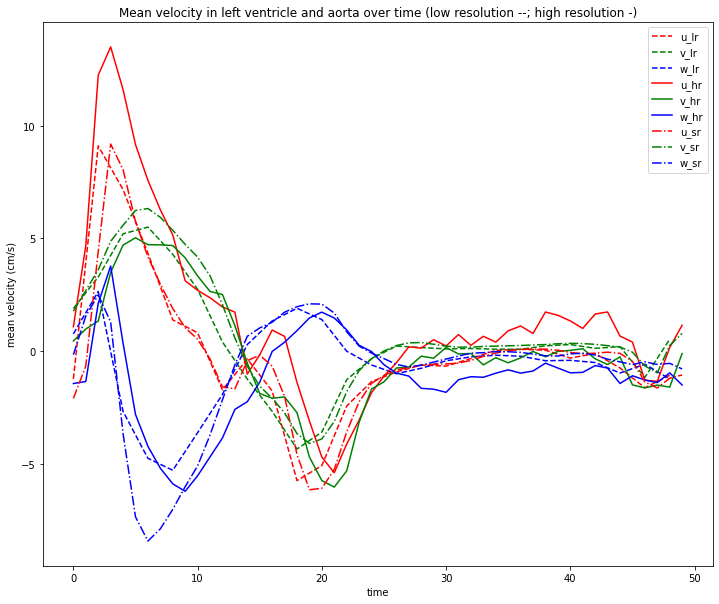

In [22]:
# plt mean velocity whole fluid region

points_mask_t = np.sum(mask) 

u_lr_mean = np.sum(lr_u*mask,axis=(1,2,3))/points_mask_t
v_lr_mean = np.sum(lr_v*mask,axis=(1,2,3))/points_mask_t
w_lr_mean = np.sum(lr_w*mask,axis=(1,2,3))/points_mask_t

u_hr_mean = np.sum(hr_u*mask, axis=(1,2,3))/points_mask_t
v_hr_mean = np.sum(hr_v*mask, axis=(1,2,3))/points_mask_t
w_hr_mean = np.sum(hr_w*mask, axis=(1,2,3))/points_mask_t

u_sr_mean = np.sum(sr_u*mask, axis=(1,2,3))/points_mask_t
v_sr_mean = np.sum(sr_v*mask, axis=(1,2,3))/points_mask_t
w_sr_mean = np.sum(sr_w*mask, axis=(1,2,3))/points_mask_t

plt.figure(figsize=(12, 10))
plt.plot(range(0, len(hr_u), 2), u_lr_mean, '--',  label='u_lr',  color = 'r')
plt.plot(range(0, len(hr_u), 2), v_lr_mean, '--',  label='v_lr',  color = 'g')
plt.plot(range(0, len(hr_u), 2), w_lr_mean, '--',  label='w_lr',  color = 'b')
plt.plot(u_hr_mean, label='u_hr',  color = 'r')
plt.plot(v_hr_mean, label='v_hr',  color = 'g')
plt.plot(w_hr_mean, label='w_hr',  color = 'b')
plt.plot(u_sr_mean, label='u_sr',  color = 'r', linestyle='-.')
plt.plot(v_sr_mean, label='v_sr',  color = 'g', linestyle='-.')
plt.plot(w_sr_mean, label='w_sr',  color = 'b', linestyle='-.')
plt.legend()
plt.xlabel('time')
plt.ylabel('mean velocity (cm/s)')
plt.title('Mean velocity in left ventricle and aorta over time (low resolution --; high resolution -)')
plt.show()

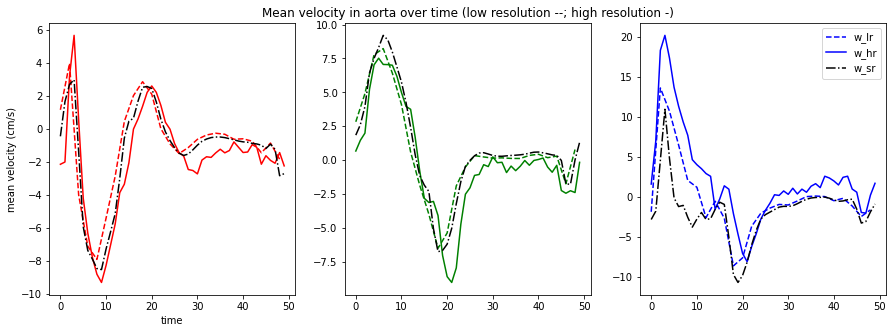

u: [(0, -2.16), (1, -2.02), (2, 3.17), (3, 5.65), (4, 0.52), (5, -4.21), (6, -6.33), (7, -7.78), (8, -8.82), (9, -9.31), (10, -8.28), (11, -7.03), (12, -5.77), (13, -3.87), (14, -3.36), (15, -2.07), (16, -0.03), (17, 0.59), (18, 1.36), (19, 2.2), (20, 2.58), (21, 2.19), (22, 1.41), (23, 0.38), (24, -0.03), (25, -0.9), (26, -1.46), (27, -1.66), (28, -2.48), (29, -2.53), (30, -2.74), (31, -1.9), (32, -1.7), (33, -1.74), (34, -1.47), (35, -1.25), (36, -1.46), (37, -1.32), (38, -0.8), (39, -1.13), (40, -1.45), (41, -1.42), (42, -0.97), (43, -1.13), (44, -2.15), (45, -1.64), (46, -1.92), (47, -2.09), (48, -1.45), (49, -2.25)]
v: [(0, 0.67), (1, 1.46), (2, 1.99), (3, 5.22), (4, 7.03), (5, 7.52), (6, 7.06), (7, 7.05), (8, 7.0), (9, 6.19), (10, 4.99), (11, 3.96), (12, 3.75), (13, 1.69), (14, -0.81), (15, -2.82), (16, -3.13), (17, -3.05), (18, -4.09), (19, -7.03), (20, -8.6), (21, -9.03), (22, -7.96), (23, -4.73), (24, -2.52), (25, -2.04), (26, -1.13), (27, -1.06), (28, -0.34), (29, -0.48), (30

In [18]:
# plot mean velocity over time in each direction - aorta

points_mask_aorta = np.sum(mask_aorta)


u_lr_mean_aorta = np.sum(lr_u*mask,axis=(1,2,3))/points_mask_aorta
v_lr_mean_aorta = np.sum(lr_v*mask,axis=(1,2,3))/points_mask_aorta
w_lr_mean_aorta = np.sum(lr_w*mask,axis=(1,2,3))/points_mask_aorta

u_hr_mean_aorta = np.sum(hr_u*mask, axis=(1,2,3))/points_mask_aorta
v_hr_mean_aorta = np.sum(hr_v*mask, axis=(1,2,3))/points_mask_aorta
w_hr_mean_aorta = np.sum(hr_w*mask, axis=(1,2,3))/points_mask_aorta

u_sr_mean_aorta = np.sum(sr_u*mask, axis=(1,2,3))/points_mask_aorta
v_sr_mean_aorta = np.sum(sr_v*mask, axis=(1,2,3))/points_mask_aorta
w_sr_mean_aorta = np.sum(sr_w*mask, axis=(1,2,3))/points_mask_aorta

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(0, len(hr_u), 2), u_lr_mean_aorta, '--', color = 'r')
plt.plot(u_hr_mean_aorta, label='u_hr',  color = 'r')
plt.plot(u_sr_mean_aorta, label='u_sr',  color = 'black', linestyle='-.')
plt.xlabel('time')
plt.ylabel('mean velocity (cm/s)')

plt.subplot(1, 3, 2)
plt.plot(range(0, len(hr_u), 2), v_lr_mean_aorta, '--', color = 'g')
plt.plot(v_hr_mean_aorta, label='v_hr',  color = 'g')
plt.plot(v_sr_mean_aorta, label='v_sr',  color = 'black', linestyle='-.')
plt.title('Mean velocity in aorta over time (low resolution --; high resolution -)')

plt.subplot(1, 3, 3)
plt.plot(range(0, len(hr_u), 2), w_lr_mean_aorta, '--', label = 'w_lr', color = 'b')
plt.plot(w_hr_mean_aorta, label='w_hr',  color = 'b')
plt.plot(w_sr_mean_aorta, label='w_sr',  color = 'black', linestyle='-.')
plt.legend()
plt.show()

vel_u_aorta_time = [(frame, u_hr_mean_aorta[frame].round(2)) for frame in range(T_hr)]
vel_v_aorta_time = [(frame, v_hr_mean_aorta[frame].round(2)) for frame in range(T_hr)]
vel_w_aorta_time = [(frame, w_hr_mean_aorta[frame].round(2)) for frame in range(T_hr)]
print('u:', vel_u_aorta_time)
print('v:', vel_v_aorta_time)
print('w:', vel_w_aorta_time)

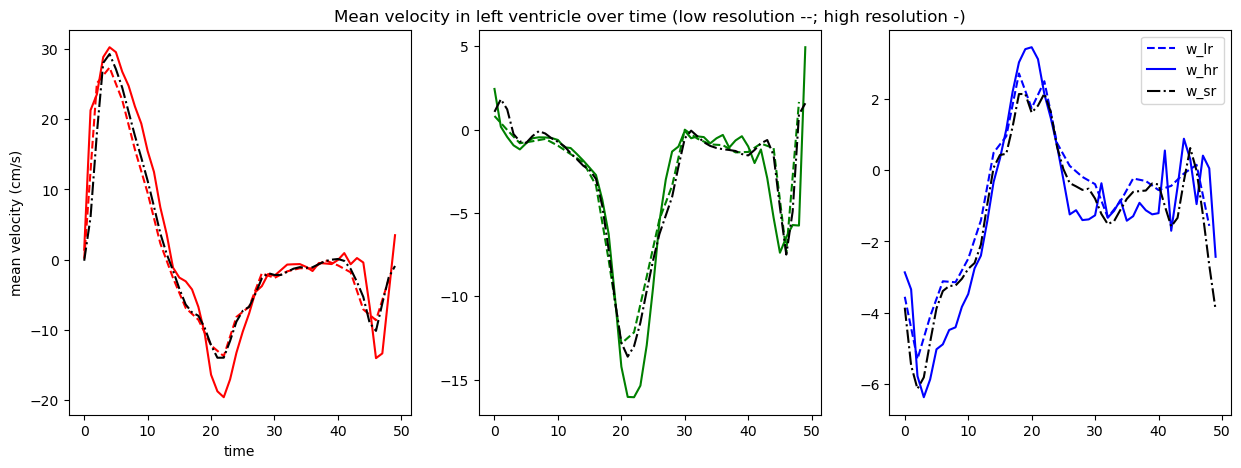

u: [(0, 1.4), (1, 21.29), (2, 23.55), (3, 28.87), (4, 30.27), (5, 29.57), (6, 26.78), (7, 24.77), (8, 21.82), (9, 19.39), (10, 15.48), (11, 12.49), (12, 7.45), (13, 3.64), (14, -1.14), (15, -2.57), (16, -3.09), (17, -4.26), (18, -6.75), (19, -10.55), (20, -16.41), (21, -18.78), (22, -19.62), (23, -17.08), (24, -13.28), (25, -10.26), (26, -7.68), (27, -4.61), (28, -3.79), (29, -2.06), (30, -2.3), (31, -1.51), (32, -0.71), (33, -0.67), (34, -0.65), (35, -1.05), (36, -1.63), (37, -0.49), (38, -0.55), (39, -0.64), (40, -0.05), (41, 0.92), (42, -0.67), (43, 0.22), (44, -0.42), (45, -6.68), (46, -14.05), (47, -13.37), (48, -4.89), (49, 3.48)]
v: [(0, 2.44), (1, 0.17), (2, -0.44), (3, -0.95), (4, -1.19), (5, -0.82), (6, -0.52), (7, -0.47), (8, -0.47), (9, -0.51), (10, -0.62), (11, -1.06), (12, -1.11), (13, -1.47), (14, -1.86), (15, -2.29), (16, -2.73), (17, -4.21), (18, -6.26), (19, -10.07), (20, -14.22), (21, -16.03), (22, -16.05), (23, -15.36), (24, -12.93), (25, -9.47), (26, -5.54), (27, -

In [43]:
# plot mean velocity for left ventricle

u_lr_mean_lv = np.mean(lr_u,axis=(1,2,3), where=mask_lv.astype(bool))
v_lr_mean_lv = np.mean(lr_v,axis=(1,2,3), where=mask_lv.astype(bool))
w_lr_mean_lv = np.mean(lr_w,axis=(1,2,3), where=mask_lv.astype(bool))

u_hr_mean_lv = np.mean(hr_u, axis=(1,2,3), where=mask_lv.astype(bool))
v_hr_mean_lv = np.mean(hr_v, axis=(1,2,3), where=mask_lv.astype(bool))
w_hr_mean_lv = np.mean(hr_w, axis=(1,2,3), where=mask_lv.astype(bool))

u_sr_mean_lv = np.mean(sr_u, axis=(1,2,3), where=mask_lv.astype(bool))
v_sr_mean_lv = np.mean(sr_v, axis=(1,2,3), where=mask_lv.astype(bool))
w_sr_mean_lv = np.mean(sr_w, axis=(1,2,3), where=mask_lv.astype(bool))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(0, len(hr_u), 2), u_lr_mean_lv, '--', color = 'r')
plt.plot(u_hr_mean_lv, label='u_hr',  color = 'r')
plt.plot(u_sr_mean_lv, label='u_sr',  color = 'black', linestyle='-.')
plt.xlabel('time')
plt.ylabel('mean velocity (cm/s)')

plt.subplot(1, 3, 2)
plt.plot(range(0, len(hr_u), 2), v_lr_mean_lv, '--', color = 'g')
plt.plot(v_hr_mean_lv, label='v_hr',  color = 'g')
plt.plot(v_sr_mean_lv, label='v_sr',  color = 'black', linestyle='-.')
plt.title('Mean velocity in left ventricle over time (low resolution --; high resolution -)')

plt.subplot(1, 3, 3)
plt.plot(range(0, len(hr_u), 2), w_lr_mean_lv, '--', label = 'w_lr', color = 'b')
plt.plot(w_hr_mean_lv, label='w_hr',  color = 'b')
plt.plot(w_sr_mean_lv, label='w_sr',  color = 'black', linestyle='-.')
plt.legend()

plt.show()

vel_u_lv_time = [(frame, u_hr_mean_lv[frame].round(2)) for frame in range(T_hr)]
vel_v_lv_time = [(frame, v_hr_mean_lv[frame].round(2)) for frame in range(T_hr)]
vel_w_lv_time = [(frame, w_hr_mean_lv[frame].round(2)) for frame in range(T_hr)]
print('u:', vel_u_lv_time)
print('v:', vel_v_lv_time)
print('w:', vel_w_lv_time)

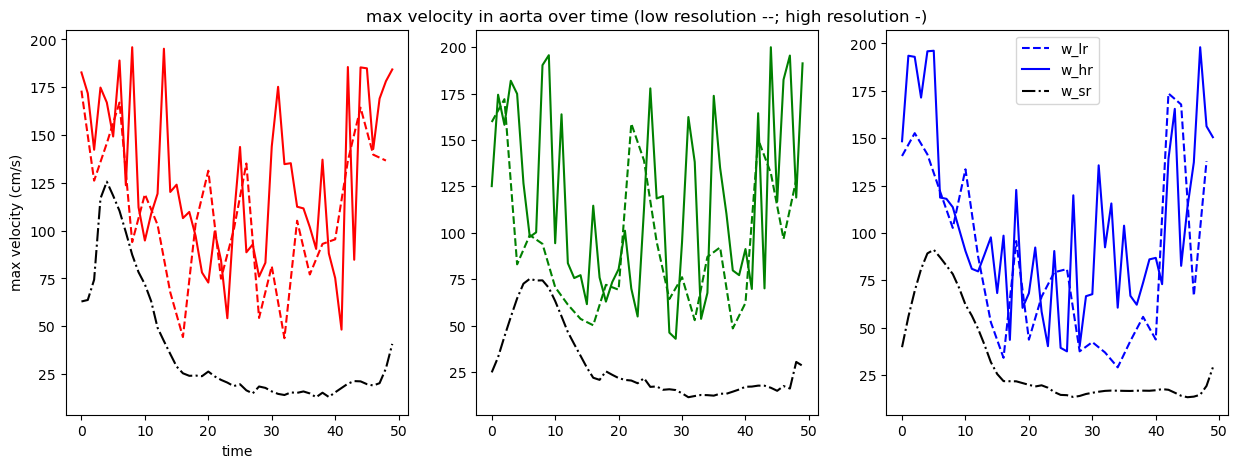

u: [(0, 1.4), (1, 21.29), (2, 23.55), (3, 28.87), (4, 30.27), (5, 29.57), (6, 26.78), (7, 24.77), (8, 21.82), (9, 19.39), (10, 15.48), (11, 12.49), (12, 7.45), (13, 3.64), (14, -1.14), (15, -2.57), (16, -3.09), (17, -4.26), (18, -6.75), (19, -10.55), (20, -16.41), (21, -18.78), (22, -19.62), (23, -17.08), (24, -13.28), (25, -10.26), (26, -7.68), (27, -4.61), (28, -3.79), (29, -2.06), (30, -2.3), (31, -1.51), (32, -0.71), (33, -0.67), (34, -0.65), (35, -1.05), (36, -1.63), (37, -0.49), (38, -0.55), (39, -0.64), (40, -0.05), (41, 0.92), (42, -0.67), (43, 0.22), (44, -0.42), (45, -6.68), (46, -14.05), (47, -13.37), (48, -4.89), (49, 3.48)]
v: [(0, 2.44), (1, 0.17), (2, -0.44), (3, -0.95), (4, -1.19), (5, -0.82), (6, -0.52), (7, -0.47), (8, -0.47), (9, -0.51), (10, -0.62), (11, -1.06), (12, -1.11), (13, -1.47), (14, -1.86), (15, -2.29), (16, -2.73), (17, -4.21), (18, -6.26), (19, -10.07), (20, -14.22), (21, -16.03), (22, -16.05), (23, -15.36), (24, -12.93), (25, -9.47), (26, -5.54), (27, -

In [44]:
# plot mean velocity for aorta

u_lr_max_aorta = np.max(np.abs(lr_u),axis=(1,2,3), where=mask_aorta.astype(bool), initial = 0)
v_lr_max_aorta = np.max(np.abs(lr_v),axis=(1,2,3), where=mask_aorta.astype(bool), initial = 0)
w_lr_max_aorta = np.max(np.abs(lr_w),axis=(1,2,3), where=mask_aorta.astype(bool), initial = 0)

u_hr_max_aorta = np.max(np.abs(hr_u), axis=(1,2,3), where=mask_aorta.astype(bool), initial = 0)
v_hr_max_aorta = np.max(np.abs(hr_v), axis=(1,2,3), where=mask_aorta.astype(bool), initial = 0)
w_hr_max_aorta = np.max(np.abs(hr_w), axis=(1,2,3), where=mask_aorta.astype(bool), initial = 0)

u_sr_max_aorta = np.max(np.abs(sr_u), axis=(1,2,3), where=mask_aorta.astype(bool), initial =0)
v_sr_max_aorta = np.max(np.abs(sr_v), axis=(1,2,3), where=mask_aorta.astype(bool), initial =0)
w_sr_max_aorta = np.max(np.abs(sr_w), axis=(1,2,3), where=mask_aorta.astype(bool), initial =0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(0, T_hr, 2), u_lr_max_aorta, '--', color = 'r')
plt.plot(u_hr_max_aorta, label='u_hr',  color = 'r')
plt.plot(u_sr_max_aorta, label='u_sr',  color = 'black', linestyle='-.')
plt.xlabel('time')
plt.ylabel('max velocity (cm/s)')

plt.subplot(1, 3, 2)
plt.plot(range(0, T_hr, 2), v_lr_max_aorta, '--', color = 'g')
plt.plot(v_hr_max_aorta, label='v_hr',  color = 'g')
plt.plot(v_sr_max_aorta, label='v_sr',  color = 'black', linestyle='-.')
plt.title('max velocity in aorta over time (low resolution --; high resolution -)')

plt.subplot(1, 3, 3)
plt.plot(range(0, T_hr, 2), w_lr_max_aorta, '--', label = 'w_lr', color = 'b')
plt.plot(w_hr_max_aorta, label='w_hr',  color = 'b')
plt.plot(w_sr_max_aorta, label='w_sr',  color = 'black', linestyle='-.')
plt.legend()

plt.show()

vel_u_aorta_time = [(frame, u_hr_max_aorta[frame].round(2)) for frame in range(T_hr)]
vel_v_aorta_time = [(frame, v_hr_max_aorta[frame].round(2)) for frame in range(T_hr)]
vel_w_aorta_time = [(frame, w_hr_max_aorta[frame].round(2)) for frame in range(T_hr)]
print('u:', vel_u_lv_time)
print('v:', vel_v_lv_time)
print('w:', vel_w_lv_time)

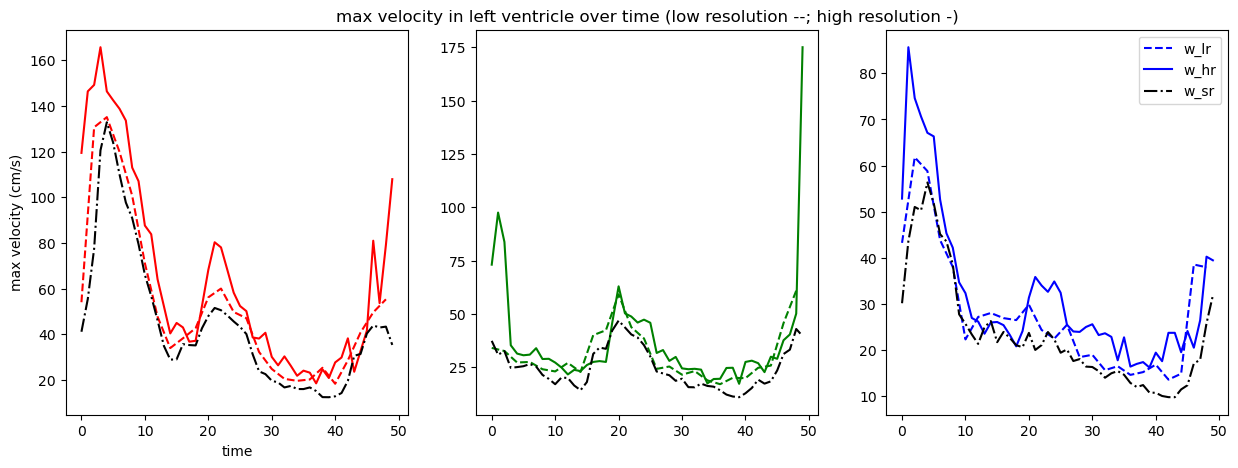

u: [(0, 119.46), (1, 146.42), (2, 149.26), (3, 165.76), (4, 146.42), (5, 142.52), (6, 138.8), (7, 133.63), (8, 113.02), (9, 107.06), (10, 87.62), (11, 83.81), (12, 64.08), (13, 52.26), (14, 40.34), (15, 44.93), (16, 42.98), (17, 36.73), (18, 37.12), (19, 52.36), (20, 68.18), (21, 80.29), (22, 78.05), (23, 68.18), (24, 58.22), (25, 52.36), (26, 50.11), (27, 38.58), (28, 38.1), (29, 40.63), (30, 30.09), (31, 26.37), (32, 30.28), (33, 26.18), (34, 21.78), (35, 24.03), (36, 23.15), (37, 18.46), (38, 24.62), (39, 20.81), (40, 27.64), (41, 29.79), (42, 38.19), (43, 23.54), (44, 32.63), (45, 41.61), (46, 80.98), (47, 53.63), (48, 79.22), (49, 107.94)]
v: [(0, 73.06), (1, 97.48), (2, 83.71), (3, 35.26), (4, 31.36), (5, 30.57), (6, 30.87), (7, 33.89), (8, 28.82), (9, 28.91), (10, 27.16), (11, 24.81), (12, 21.59), (13, 23.74), (14, 23.15), (15, 25.98), (16, 27.45), (17, 27.84), (18, 27.45), (19, 45.91), (20, 62.91), (21, 50.21), (22, 48.74), (23, 45.91), (24, 47.28), (25, 45.81), (26, 31.65), (2

In [45]:
# plot mean velocity for left ventricle

u_lr_max_lv = np.max(np.abs(lr_u),axis=(1,2,3), where=mask_lv.astype(bool), initial = 0)
v_lr_max_lv = np.max(np.abs(lr_v),axis=(1,2,3), where=mask_lv.astype(bool), initial = 0)
w_lr_max_lv = np.max(np.abs(lr_w),axis=(1,2,3), where=mask_lv.astype(bool), initial = 0)

u_hr_max_lv = np.max(np.abs(hr_u), axis=(1,2,3), where=mask_lv.astype(bool), initial = 0)
v_hr_max_lv = np.max(np.abs(hr_v), axis=(1,2,3), where=mask_lv.astype(bool), initial = 0)
w_hr_max_lv = np.max(np.abs(hr_w), axis=(1,2,3), where=mask_lv.astype(bool), initial = 0)

u_sr_max_lv = np.max(np.abs(sr_u), axis=(1,2,3), where=mask_lv.astype(bool), initial =0)
v_sr_max_lv = np.max(np.abs(sr_v), axis=(1,2,3), where=mask_lv.astype(bool), initial =0)
w_sr_max_lv = np.max(np.abs(sr_w), axis=(1,2,3), where=mask_lv.astype(bool), initial =0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(0, T_hr, 2), u_lr_max_lv, '--', color = 'r')
plt.plot(u_hr_max_lv, label='u_hr',  color = 'r')
plt.plot(u_sr_max_lv, label='u_sr',  color = 'black', linestyle='-.')
plt.xlabel('time')
plt.ylabel('max velocity (cm/s)')

plt.subplot(1, 3, 2)
plt.plot(range(0, T_hr, 2), v_lr_max_lv, '--', color = 'g')
plt.plot(v_hr_max_lv, label='v_hr',  color = 'g')
plt.plot(v_sr_max_lv, label='v_sr',  color = 'black', linestyle='-.')
plt.title('max velocity in left ventricle over time (low resolution --; high resolution -)')

plt.subplot(1, 3, 3)
plt.plot(range(0, T_hr, 2), w_lr_max_lv, '--', label = 'w_lr', color = 'b')
plt.plot(w_hr_max_lv, label='w_hr',  color = 'b')
plt.plot(w_sr_max_lv, label='w_sr',  color = 'black', linestyle='-.')
plt.legend()

plt.show()

vel_u_lv_time = [(frame, u_hr_max_lv[frame].round(2)) for frame in range(T_hr)]
vel_v_lv_time = [(frame, v_hr_max_lv[frame].round(2)) for frame in range(T_hr)]
vel_w_lv_time = [(frame, w_hr_max_lv[frame].round(2)) for frame in range(T_hr)]
print('u:', vel_u_lv_time)
print('v:', vel_v_lv_time)
print('w:', vel_w_lv_time)

max mean velocity frame u in aorta: 9 8.988113931695763
max mean velocity frame v in aorta: 5 9.664771636032118
max mean velocity frame w in aorta: 2 10.528584369841955
max mean velocity frame u in lv: 4 30.271265348188397
max mean velocity frame v in lv: 22 4.938145245837557
max mean velocity frame w in lv: 3 3.4597031520108437


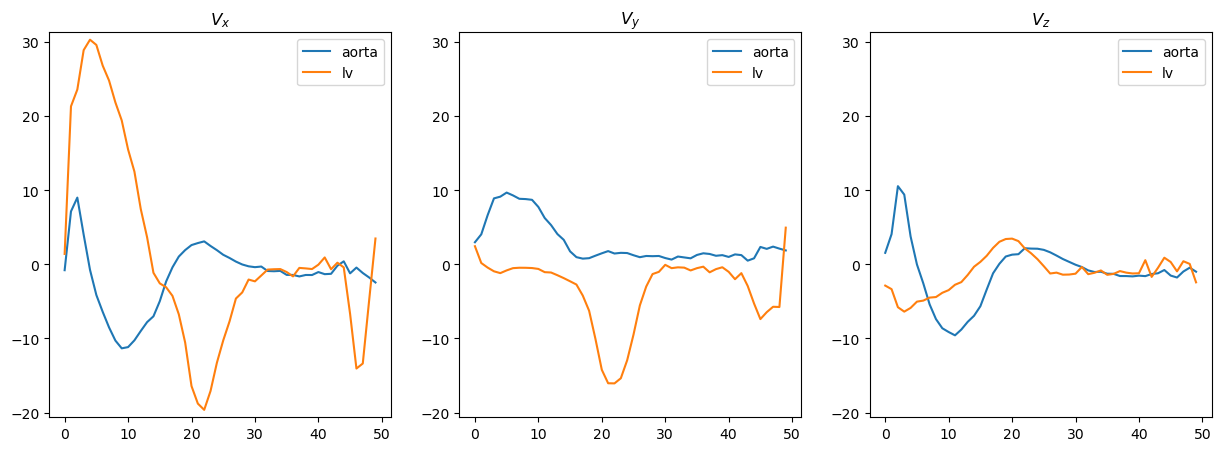

In [46]:
# get max and min velocity frames 

print('max mean velocity frame u in aorta:', np.argmax(np.abs(u_hr_mean_aorta)), np.max(u_hr_mean_aorta))
print('max mean velocity frame v in aorta:', np.argmax(np.abs(v_hr_mean_aorta)), np.max(v_hr_mean_aorta))
print('max mean velocity frame w in aorta:', np.argmax(np.abs(w_hr_mean_aorta)), np.max(w_hr_mean_aorta))

print('max mean velocity frame u in lv:', np.argmax(np.abs(u_hr_mean_lv)), np.max(u_hr_mean_lv))
print('max mean velocity frame v in lv:', np.argmax(np.abs(v_hr_mean_lv)), np.max(v_hr_mean_lv))
print('max mean velocity frame w in lv:', np.argmax(np.abs(w_hr_mean_lv)), np.max(w_hr_mean_lv))

# three subplots for u, v, w
# scale to same y axis
plt.figure(figsize=(15, 5))

# Determine the common y-axis limits
y_min = min(np.min(u_hr_mean_aorta), np.min(u_hr_mean_lv), np.min(v_hr_mean_aorta), np.min(v_hr_mean_lv), np.min(w_hr_mean_aorta), np.min(w_hr_mean_lv))-1
y_max = max(np.max(u_hr_mean_aorta), np.max(u_hr_mean_lv), np.max(v_hr_mean_aorta), np.max(v_hr_mean_lv), np.max(w_hr_mean_aorta), np.max(w_hr_mean_lv))+1

plt.subplot(1, 3, 1)
plt.plot(u_hr_mean_aorta, label='aorta')
plt.plot(u_hr_mean_lv, label='lv')
plt.legend()
plt.title(r'$V_x$')
plt.ylim(y_min, y_max)

plt.subplot(1, 3, 2)
plt.plot(v_hr_mean_aorta, label='aorta')
plt.plot(v_hr_mean_lv, label='lv')
plt.legend()
plt.title(r'$V_y$')
plt.ylim(y_min, y_max)

plt.subplot(1, 3, 3)
plt.plot(w_hr_mean_aorta, label='aorta')
plt.plot(w_hr_mean_lv, label='lv')
plt.legend()
plt.title(r'$V_z$')
plt.ylim(y_min, y_max)

plt.show()



In [ ]:
# define peak systole in aorta and peak diastole in left ventricle

# choose the frame with the maximum mean velocity in aorta as the peak systole
t_peak_systole_aorta = np.argmax(np.abs([u_hr_mean_aorta, v_hr_mean_aorta, w_hr_mean_aorta]), axis=1)
t_peak_diastole_lv = np.argmax(np.abs([u_hr_mean_lv, v_hr_mean_lv, w_hr_mean_lv]), axis=1)

# get second peak systole in aorta
t_peak2_systole_aorta = np.argsort(np.abs(u_hr_mean_aorta))[::-1]
print('Second peak systole in aorta:', t_peak2_systole_aorta)

# get second peak diastole in left ventricle
t_peak2_diastole_lv = np.argsort(np.abs(u_hr_mean_lv))[::-1]
print('Second peak diastole in left ventricle:', t_peak2_diastole_lv)

print('Peak systole in aorta:', t_peak_systole_aorta)
print('Peak diastole in left ventricle:', t_peak_diastole_lv)

t_peak_systole_aorta = t_peak_systole_aorta[0]
t_peak_diastole_lv = t_peak_diastole_lv[1]

Correlation plots

Plotting correlation lines...


C:\Users\piacal\AppData\Local\Temp\ipykernel_3760\3553124159.py:107: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


Plotting correlation lines...


C:\Users\piacal\AppData\Local\Temp\ipykernel_3760\3553124159.py:128: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


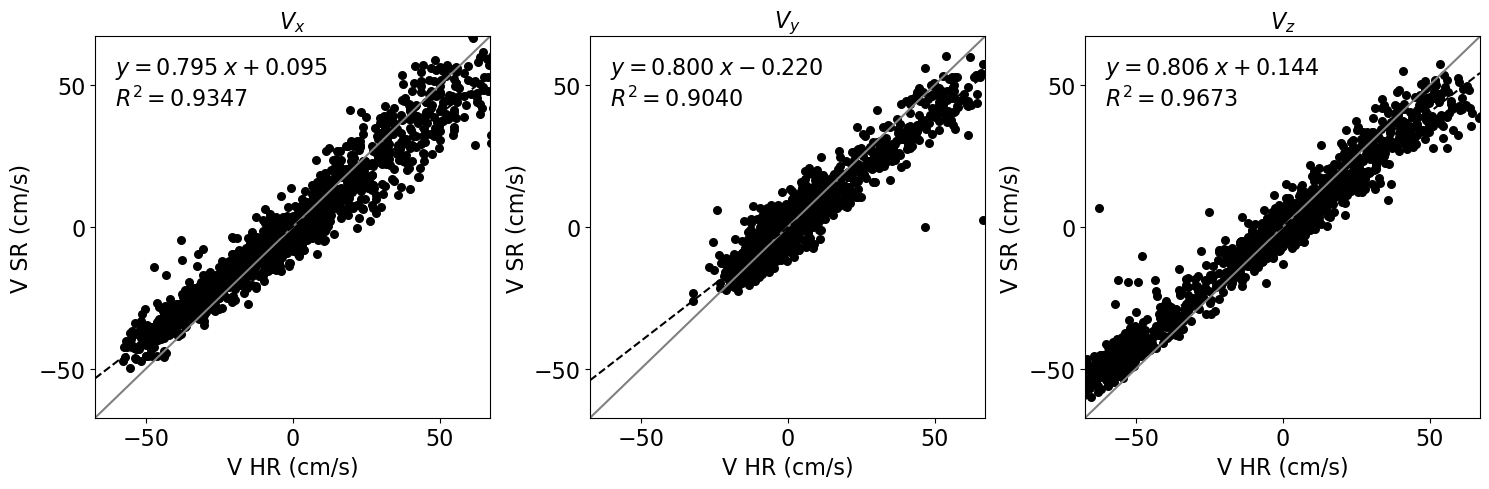

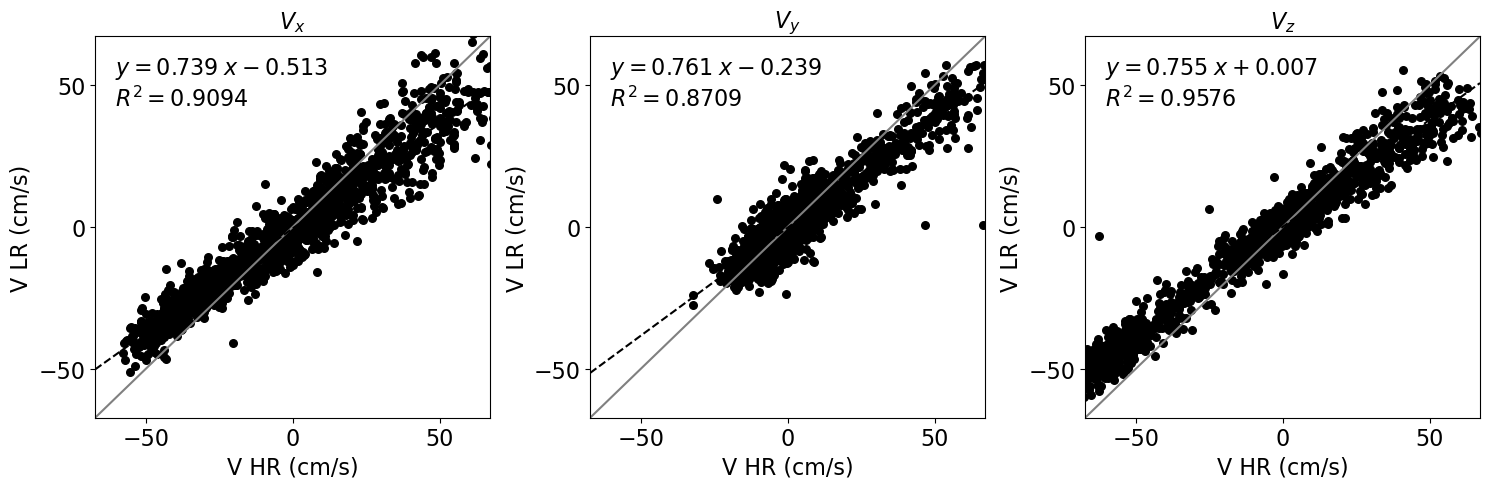

In [47]:
# plot correlation between high and super-resoluton data

# correlation between low and high resolution velocity fields

frame_idx = 10

fontsize = 16
# set percentage of how many random points are used
p = 0.1

# get indices of core 
idx_core = np.where(mask == 1)

# get random indices for core to plot a subset of the points
x_idx, y_idx, z_idx = random_indices3D((mask), n=int(p*np.count_nonzero(mask)))

# Get velocity values in all directions
# HR
hr_u_rnd = hr_u[frame_idx, x_idx, y_idx, z_idx]
hr_v_rnd = hr_v[frame_idx, x_idx, y_idx, z_idx]
hr_w_rnd = hr_w[frame_idx, x_idx, y_idx, z_idx]

# LR 
sr_u_rnd = sr_u[frame_idx, x_idx, y_idx, z_idx]
sr_v_rnd = sr_v[frame_idx, x_idx, y_idx, z_idx]
sr_w_rnd = sr_w[frame_idx, x_idx, y_idx, z_idx]

def plot_regression_points(hr_vals, sr_vals, all_hr, all_sr, direction = 'u', title_y = 'SR'):
    N = 100
    # make sure that the range is the same for all plots and make square range
    x_range = np.linspace(-abs_max, abs_max, N)
    
    corr_line, text = get_corr_line_and_r2(all_hr, all_sr, x_range)

    # plot linear correlation line and parms
    
    plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes, fontsize=fontsize, verticalalignment='top')
    plt.plot(x_range, x_range, color= 'grey', label = 'diagonal line')
    plt.plot(x_range, corr_line, 'k--')
    plt.scatter(hr_vals, sr_vals, s=30, c='black', label = 'core voxels')
    
    plt.title(direction, fontsize=fontsize)
    plt.xlabel("V HR (cm/s)", fontsize=fontsize)
    plt.ylabel(f"V {title_y} (cm/s)", fontsize=fontsize)
    plt.ylim(-abs_max, abs_max)
    plt.xlim(-abs_max, abs_max)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=3)
    plt.tick_params(axis='y', labelsize = fontsize)
    plt.tick_params(axis='x', labelsize = fontsize)

def get_corr_line_and_r2(hr_vals, sr_vals, x_range):
    '''
    Returns correlation line and text for plot
    '''
    z = np.polyfit(hr_vals, sr_vals, 1)
    corr_line = np.poly1d(z)(x_range)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(hr_vals, sr_vals)
    text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r_value**2:0.4f}$"
    
    return corr_line, text


def plot_correlation_paired_invivo(v_hr, v_sr, mask,frame_idx,  p=0.1, fontsize = 16, direction = '$V$', save_as = None):

    # get indices of core 
    idx_core = np.where(mask == 1)

    # get random indices for core to plot a subset of the points
    x_idx, y_idx, z_idx = random_indices3D((mask), n=int(p*np.count_nonzero(mask)))

    # Get velocity values in all directions
    # HR
    hr_u_rnd = hr_u[frame_idx, x_idx, y_idx, z_idx]
    hr_v_rnd = hr_v[frame_idx, x_idx, y_idx, z_idx]
    hr_w_rnd = hr_w[frame_idx, x_idx, y_idx, z_idx]

    # LR 
    if v_hr.shape[0] != v_sr.shape[0]:
        frame_idx_sr = frame_idx//int(v_hr.shape[0]/v_sr.shape[0])
        print(f'Frame idx for sr changed to frame_idx_sr: {frame_idx_sr}')
    else:
        frame_idx_sr = frame_idx

    sr_u_rnd = sr_u[frame_idx_sr, x_idx, y_idx, z_idx]
    sr_v_rnd = sr_v[frame_idx_sr, x_idx, y_idx, z_idx]
    sr_w_rnd = sr_w[frame_idx_sr, x_idx, y_idx, z_idx]

    plot_regression_points(hr_u_rnd, sr_u_rnd, hr_u[frame_idx][idx_core], sr_u[frame_idx_sr][idx_core], direction=direction)
    plt.tight_layout()
    if save_as is not None:
        plt.savefig(save_as)





    
print("Plotting correlation lines...")

min_vals = np.min([np.min(sr_u_rnd), np.min(sr_v_rnd), np.min(sr_w_rnd)])
max_vals = np.max([np.max(sr_u_rnd), np.max(sr_v_rnd), np.max(sr_w_rnd)])
abs_max  = np.max([np.abs(min_vals), np.abs(max_vals)])

plt.figure(figsize=(15, 5))
plt.title(f'Velocity correlation between HR and SR data at frame {frame_idx}')
plt.subplot(1, 3, 1)
plot_regression_points(hr_u_rnd, sr_u_rnd, hr_u[frame_idx][idx_core], sr_u[frame_idx][idx_core], direction=r'$V_x$')
plt.subplot(1, 3, 2)
plot_regression_points(hr_v_rnd, sr_v_rnd, hr_v[frame_idx][idx_core], sr_v[frame_idx][idx_core], direction=r'$V_y$')
plt.subplot(1, 3, 3)
plot_regression_points(hr_w_rnd, sr_w_rnd, hr_w[frame_idx][idx_core], sr_w[frame_idx][idx_core], direction=r'$V_z$')
plt.tight_layout()

# correlation between low and high resolution velocity fields


# LR 
lr_u_rnd = lr_u[frame_idx//2, x_idx, y_idx, z_idx]
lr_v_rnd = lr_v[frame_idx//2, x_idx, y_idx, z_idx]
lr_w_rnd = lr_w[frame_idx//2, x_idx, y_idx, z_idx]

print("Plotting correlation lines...")


plt.figure(figsize=(15, 5))
plt.title(f'Velocity correlation between HR and LR data in frame {frame_idx}')
plt.subplot(1, 3, 1)
plot_regression_points(hr_u_rnd, lr_u_rnd, hr_u[frame_idx][idx_core], lr_u[frame_idx//2][idx_core], direction=r'$V_x$', title_y='LR')
plt.subplot(1, 3, 2)
plot_regression_points(hr_v_rnd, lr_v_rnd, hr_v[frame_idx][idx_core], lr_v[frame_idx//2][idx_core], direction=r'$V_y$', title_y='LR')
plt.subplot(1, 3, 3)
plot_regression_points(hr_w_rnd, lr_w_rnd, hr_w[frame_idx][idx_core], lr_w[frame_idx//2][idx_core], direction=r'$V_z$', title_y='LR')
plt.tight_layout()



In [ ]:
# correlation plot only for aorta
frame_idx = 10

# get indices of core
idx_aorta = np.where(mask_aorta == 1)

# get random indices for core to plot a subset of the points
x_idx, y_idx, z_idx = random_indices3D((mask_aorta), n=int(p*np.count_nonzero(mask_aorta)))

# Get velocity values in all directions
# HR
hr_u_rnd = hr_u[frame_idx, x_idx, y_idx, z_idx]
hr_v_rnd = hr_v[frame_idx, x_idx, y_idx, z_idx]
hr_w_rnd = hr_w[frame_idx, x_idx, y_idx, z_idx]

# SR
sr_u_rnd = sr_u[frame_idx, x_idx, y_idx, z_idx]
sr_v_rnd = sr_v[frame_idx, x_idx, y_idx, z_idx]
sr_w_rnd = sr_w[frame_idx, x_idx, y_idx, z_idx]

# LR
lr_u_rnd = lr_u[frame_idx//2, x_idx, y_idx, z_idx]
lr_v_rnd = lr_v[frame_idx//2, x_idx, y_idx, z_idx]
lr_w_rnd = lr_w[frame_idx//2, x_idx, y_idx, z_idx]

print("Plotting correlation lines...")
plt.figure(figsize=(15, 5))
plt.title(f'Velocity correlation between HR and SR data in frame {frame_idx}')
plt.subplot(1, 3, 1)
plot_regression_points(hr_u_rnd, sr_u_rnd, hr_u[frame_idx][idx_aorta], sr_u[frame_idx][idx_aorta], direction=r'$V_x$')
plt.subplot(1, 3, 2)
plot_regression_points(hr_v_rnd, sr_v_rnd, hr_v[frame_idx][idx_aorta], sr_v[frame_idx][idx_aorta], direction=rf'$V_y$ - frame {frame_idx} - aorta')
plt.subplot(1, 3, 3)
plot_regression_points(hr_w_rnd, sr_w_rnd, hr_w[frame_idx][idx_aorta], sr_w[frame_idx][idx_aorta], direction=r'$V_z$')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
plt.title(f'Velocity correlation between HR and LR data in frame {frame_idx}')
plt.subplot(1, 3, 1)
plot_regression_points(hr_u_rnd, lr_u_rnd, hr_u[frame_idx][idx_aorta], lr_u[frame_idx//2][idx_aorta], direction=r'$V_x$', title_y='LR')
plt.subplot(1, 3, 2)
plot_regression_points(hr_v_rnd, lr_v_rnd, hr_v[frame_idx][idx_aorta], lr_v[frame_idx//2][idx_aorta], direction=rf'$V_y$ - frame {frame_idx} - aorta', title_y='LR')
plt.subplot(1, 3, 3)
plot_regression_points(hr_w_rnd, lr_w_rnd, hr_w[frame_idx][idx_aorta], lr_w[frame_idx//2][idx_aorta], direction=r'$V_z$', title_y='LR')
plt.tight_layout()


In [ ]:
# correlation plot only for left ventricle
frame_idx = 24

# get indices of core
idx_lv = np.where(mask_lv == 1)

# get random indices for core to plot a subset of the points
x_idx, y_idx, z_idx = random_indices3D((mask_lv), n=int(p*np.count_nonzero(mask_lv)))

# Get velocity values in all directions
# HR
hr_u_rnd = hr_u[frame_idx, x_idx, y_idx, z_idx]
hr_v_rnd = hr_v[frame_idx, x_idx, y_idx, z_idx]
hr_w_rnd = hr_w[frame_idx, x_idx, y_idx, z_idx]

# SR
sr_u_rnd = sr_u[frame_idx, x_idx, y_idx, z_idx]
sr_v_rnd = sr_v[frame_idx, x_idx, y_idx, z_idx]
sr_w_rnd = sr_w[frame_idx, x_idx, y_idx, z_idx]

# LR
lr_u_rnd = lr_u[frame_idx//2, x_idx, y_idx, z_idx]
lr_v_rnd = lr_v[frame_idx//2, x_idx, y_idx, z_idx]
lr_w_rnd = lr_w[frame_idx//2, x_idx, y_idx, z_idx]

print("Plotting correlation lines...")
plt.figure(figsize=(15, 5))
plt.title(f'Velocity correlation between HR and SR data in frame {frame_idx}')
plt.subplot(1, 3, 1)
plot_regression_points(hr_u_rnd, sr_u_rnd, hr_u[frame_idx][idx_lv], sr_u[frame_idx][idx_lv], direction=r'$V_x$')
plt.subplot(1, 3, 2)
plot_regression_points(hr_v_rnd, sr_v_rnd, hr_v[frame_idx][idx_lv], sr_v[frame_idx][idx_lv], direction=rf'$V_y$ - frame {frame_idx} - left ventricle')
plt.subplot(1, 3, 3)
plot_regression_points(hr_w_rnd, sr_w_rnd, hr_w[frame_idx][idx_lv], sr_w[frame_idx][idx_lv], direction=r'$V_z$')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
plt.title(f'Velocity correlation between HR and LR data in frame {frame_idx}')
plt.subplot(1, 3, 1)
plot_regression_points(hr_u_rnd, lr_u_rnd, hr_u[frame_idx][idx_lv], lr_u[frame_idx//2][idx_lv], direction=r'$V_x$', title_y='LR')
plt.subplot(1, 3, 2)
plot_regression_points(hr_v_rnd, lr_v_rnd, hr_v[frame_idx][idx_lv], lr_v[frame_idx//2][idx_lv], direction=rf'$V_y$ - frame {frame_idx} - left ventricle', title_y='LR')
plt.subplot(1, 3, 3)
plot_regression_points(hr_w_rnd, lr_w_rnd, hr_w[frame_idx][idx_lv], lr_w[frame_idx//2][idx_lv], direction=r'$V_z$', title_y='LR')
plt.tight_layout()

In [158]:
#create gif from hr data in grayscale 


spatial_idx = np.index_exp[59, :, :]


#load magnitude 
with h5py.File(f'{hr_dir}/{hr_filename}', 'r') as f:
    hr_mag = np.array(f['mag_u'])

min_u_all  = np.min(np.array([np.min(hr_u), np.min(lr_u), np.min(sr_u)]))
max_u_all  = np.max(np.array([np.max(hr_u), np.max(lr_u), np.max(sr_u)]))

# animate_data_over_time_gif(spatial_idx, hr_u,  min_u_all, max_u_all, save_as = f'Animate_{hr_filename[:-3]}_hru_Greys', fps =10,  colormap = 'Greys', show_colorbar = False)
# animate_data_over_time_gif(spatial_idx, hr_v,  min_u_all, max_u_all, save_as = f'Animate_{hr_filename[:-3]}_hrv_Greys', fps =10,  colormap = 'Greys', show_colorbar = False)
# animate_data_over_time_gif(spatial_idx, hr_w,  min_u_all, max_u_all, save_as = f'Animate_{hr_filename[:-3]}_hrw_Greys', fps =10,  colormap = 'Greys', show_colorbar = False)
# animate_data_over_time_gif(spatial_idx, hr_mag,  None, None, save_as = f'Animate_{hr_filename[:-3]}_mag_Greys', fps =10,  colormap = 'Greys_r', show_colorbar = False)

# animate_data_over_time_gif(spatial_idx, lr_u,  min_u, max_u, save_as = f'Animate_{hr_filename[:-3]}_lru_idx59_new', fps = 5,  colormap = 'viridis', show_colorbar = False)
# animate_data_over_time_gif(spatial_idx, lr_v,  min_v, max_v, save_as = f'Animate_{hr_filename[:-3]}_lrv_idx59_new', fps = 5,  colormap = 'viridis', show_colorbar = False)
# animate_data_over_time_gif(spatial_idx, lr_w,  min_w, max_w, save_as = f'Animate_{hr_filename[:-3]}_lrw_idx59_new', fps = 5,  colormap = 'viridis', show_colorbar = False)

# animate_data_over_time_gif(spatial_idx, sr_u,  min_u, max_u, save_as = f'Animate_{hr_filename[:-3]}_su_idx59_new', fps =10,  colormap = 'viridis', show_colorbar = False)
# animate_data_over_time_gif(spatial_idx, sr_v,  min_v, max_v, save_as = f'Animate_{hr_filename[:-3]}_sv_idx59_new', fps =10,  colormap = 'viridis', show_colorbar = False)
# animate_data_over_time_gif(spatial_idx, sr_w,  min_w, max_w, save_as = f'Animate_{hr_filename[:-3]}_sw_idx59_new', fps =10,  colormap = 'viridis', show_colorbar = False)

# animate_data_over_time_gif(spatial_idx, hr_u*mask,  min_u, max_u, save_as = f'Animate_{hr_filename[:-3]}_hru_idx59_masked_new', fps =10,  colormap = 'viridis', show_colorbar = False)
# animate_data_over_time_gif(spatial_idx, hr_v*mask,  min_v, max_v, save_as = f'Animate_{hr_filename[:-3]}_hrv_idx59_masked_new', fps =10,  colormap = 'viridis', show_colorbar = False)
# animate_data_over_time_gif(spatial_idx, hr_w*mask,  min_w, max_w, save_as = f'Animate_{hr_filename[:-3]}_hrw_idx59_masked_new', fps =10,  colormap = 'viridis', show_colorbar = False)

# animate_data_over_time_gif(spatial_idx, lr_u*mask,  min_u, max_u, save_as = f'Animate_{hr_filename[:-3]}_lru_idx59_masked_new', fps = 5,  colormap = 'viridis', show_colorbar = False)
# animate_data_over_time_gif(spatial_idx, lr_v*mask,  min_v, max_v, save_as = f'Animate_{hr_filename[:-3]}_lrv_idx59_masked_new', fps = 5,  colormap = 'viridis', show_colorbar = False)
# animate_data_over_time_gif(spatial_idx, lr_w*mask,  min_w, max_w, save_as = f'Animate_{hr_filename[:-3]}_lrw_idx59_masked_new', fps = 5,  colormap = 'viridis', show_colorbar = False)

# animate_data_over_time_gif(spatial_idx, np.abs(sr_u-hr_u)*mask,  None, None, save_as = f'Animate_{hr_filename[:-3]}_abs_diff_u_idx59_mask', fps =10,  colormap = 'viridis', show_colorbar = True)
# animate_data_over_time_gif(spatial_idx, np.abs(sr_v-hr_v)*mask,  min_v, max_v, save_as = f'Animate_{hr_filename[:-3]}_abs_diff_v_idx59_mask', fps =10,  colormap = 'viridis', show_colorbar = True)
# animate_data_over_time_gif(spatial_idx, np.abs(sr_w-hr_w)*mask,  min_w, max_w, save_as = f'Animate_{hr_filename[:-3]}_abs_diff_w_idx59_mask', fps =10,  colormap = 'viridis', show_colorbar = True)


#### k and $R^2$ values

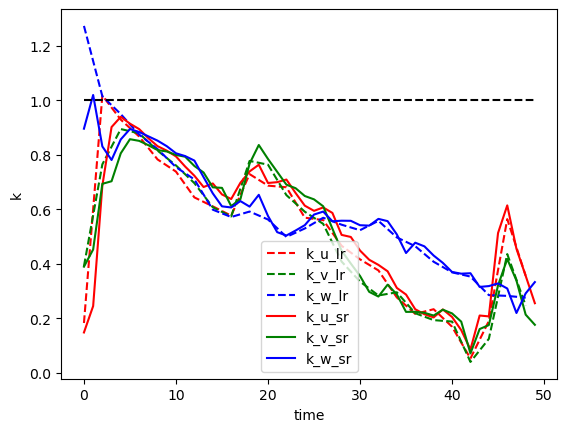

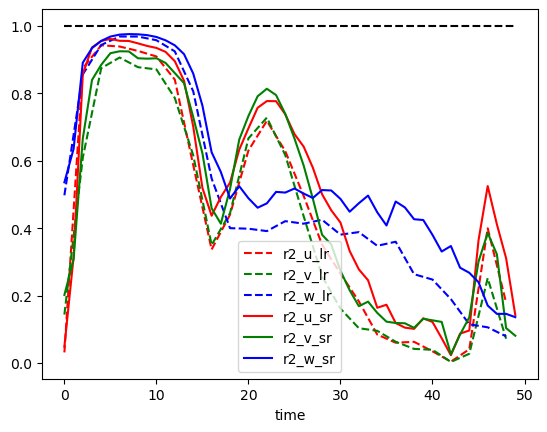

In [48]:
# plot k and r2 values for each direction over time 


k_u_lrhr, r2_u_lrhr = calculate_k_R2_timeseries(lr_u, hr_u[::2], np.repeat(mask[np.newaxis, ...], T_lr, axis=0))
k_v_lrhr, r2_v_lrhr = calculate_k_R2_timeseries(lr_v, hr_v[::2], np.repeat(mask[np.newaxis, ...], T_lr, axis=0))
k_w_lrhr, r2_w_lrhr = calculate_k_R2_timeseries(lr_w, hr_w[::2], np.repeat(mask[np.newaxis, ...], T_lr, axis=0))

k_u_srhr, r2_u_srhr = calculate_k_R2_timeseries(sr_u, hr_u, np.repeat(mask[np.newaxis, ...], T_hr, axis=0))
k_v_srhr, r2_v_srhr = calculate_k_R2_timeseries(sr_v, hr_v, np.repeat(mask[np.newaxis, ...], T_hr, axis=0))
k_w_srhr, r2_w_srhr = calculate_k_R2_timeseries(sr_w, hr_w, np.repeat(mask[np.newaxis, ...], T_hr, axis=0))

plt.figure()
plt.plot(range(0, T_hr, 2), k_u_lrhr,'--', label='k_u_lr', color = 'r')
plt.plot(range(0, T_hr, 2), k_v_lrhr,'--', label='k_v_lr', color = 'g')
plt.plot(range(0, T_hr, 2), k_w_lrhr,'--', label='k_w_lr', color = 'b')
plt.plot(range(0, T_hr), k_u_srhr, label='k_u_sr', color = 'r')
plt.plot(range(0, T_hr), k_v_srhr, label='k_v_sr', color = 'g')
plt.plot(range(0, T_hr), k_w_srhr, label='k_w_sr', color = 'b')
plt.plot(range(0, T_hr), np.ones(T_hr), '--', color='black')
plt.xlabel('time')
plt.ylabel('k')
plt.legend()

plt.figure()
plt.plot(range(0, T_hr, 2), r2_u_lrhr, '--', label='r2_u_lr', color = 'r')
plt.plot(range(0, T_hr, 2), r2_v_lrhr, '--', label='r2_v_lr', color = 'g')
plt.plot(range(0, T_hr, 2), r2_w_lrhr, '--', label='r2_w_lr', color = 'b')
plt.plot(range(0, T_hr), r2_u_srhr, label='r2_u_sr', color = 'r')
plt.plot(range(0, T_hr), r2_v_srhr, label='r2_v_sr', color = 'g')
plt.plot(range(0, T_hr), r2_w_srhr, label='r2_w_sr', color = 'b')
plt.plot(range(0, T_hr), np.ones(T_hr), '--', color='black')
plt.xlabel('time')

plt.legend()

In [ ]:
# plot k and r2 values for each direction over time 

k_u_lrhr_aorta, r2_u_lrhr_aorta = calculate_k_R2_timeseries(lr_u, hr_u[::2], np.repeat(mask_aorta[np.newaxis, ...], T_lr, axis=0))
k_v_lrhr_aorta, r2_v_lrhr_aorta = calculate_k_R2_timeseries(lr_v, hr_v[::2], np.repeat(mask_aorta[np.newaxis, ...], T_lr, axis=0))
k_w_lrhr_aorta, r2_w_lrhr_aorta = calculate_k_R2_timeseries(lr_w, hr_w[::2], np.repeat(mask_aorta[np.newaxis, ...], T_lr, axis=0))

k_u_srhr_aorta, r2_u_srhr_aorta = calculate_k_R2_timeseries(sr_u, hr_u, np.repeat(mask_aorta[np.newaxis, ...], T_hr, axis=0))
k_v_srhr_aorta, r2_v_srhr_aorta = calculate_k_R2_timeseries(sr_v, hr_v, np.repeat(mask_aorta[np.newaxis, ...], T_hr, axis=0))
k_w_srhr_aorta, r2_w_srhr_aorta = calculate_k_R2_timeseries(sr_w, hr_w, np.repeat(mask_aorta[np.newaxis, ...], T_hr, axis=0))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(0, T_hr, 2), k_u_lrhr_aorta,'--', label='k_u_lr', color = 'r')
plt.plot(range(0, T_hr), k_u_srhr_aorta, label='k_u_sr', color = 'r')
plt.plot(range(0, T_hr, 2), r2_u_lrhr_aorta, '--', label='r2_u_lr', color = 'purple')
plt.plot(range(0, T_hr), r2_u_srhr_aorta, label='r2_u_sr', color = 'purple')
plt.xlabel('time')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(0, T_hr, 2), k_v_lrhr_aorta,'--', label='k_v_lr', color = 'lightgreen')
plt.plot(range(0, T_hr), k_v_srhr_aorta, label='k_v_sr', color = 'lightgreen')
plt.plot(range(0, T_hr, 2), r2_v_lrhr_aorta, '--', label='r2_v_lr', color = 'forestgreen')
plt.plot(range(0, T_hr), r2_v_srhr_aorta, label='r2_v_sr', color = 'forestgreen')
plt.xlabel('time')
plt.legend()
plt.title('k and r2 in aorta')

plt.subplot(1, 3, 3)
plt.plot(range(0, T_hr, 2), k_w_lrhr_aorta,'--', label='k_w_lr', color = 'b')
plt.plot(range(0, T_hr), k_w_srhr_aorta, label='k_w_sr', color = 'b')
plt.plot(range(0, T_hr, 2), r2_w_lrhr_aorta, '--', label='r2_w_lr', color = 'lightblue')
plt.plot(range(0, T_hr), r2_w_srhr_aorta, label='r2_w_sr', color = 'lightblue')
plt.xlabel('time')
# plt.ylabel('k aorta')
plt.legend()
plt.tight_layout()


In [ ]:
# plot k and r2 values for each direction over time 

k_u_lrhr_lv, r2_u_lrhr_lv = calculate_k_R2_timeseries(lr_u, hr_u[::2], np.repeat(mask_lv[np.newaxis, ...], T_lr, axis=0))
k_v_lrhr_lv, r2_v_lrhr_lv = calculate_k_R2_timeseries(lr_v, hr_v[::2], np.repeat(mask_lv[np.newaxis, ...], T_lr, axis=0))
k_w_lrhr_lv, r2_w_lrhr_lv = calculate_k_R2_timeseries(lr_w, hr_w[::2], np.repeat(mask_lv[np.newaxis, ...], T_lr, axis=0))

k_u_srhr_lv, r2_u_srhr_lv = calculate_k_R2_timeseries(sr_u, hr_u, np.repeat(mask_lv[np.newaxis, ...], T_hr, axis=0))
k_v_srhr_lv, r2_v_srhr_lv = calculate_k_R2_timeseries(sr_v, hr_v, np.repeat(mask_lv[np.newaxis, ...], T_hr, axis=0))
k_w_srhr_lv, r2_w_srhr_lv = calculate_k_R2_timeseries(sr_w, hr_w, np.repeat(mask_lv[np.newaxis, ...], T_hr, axis=0))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(0, T_hr, 2), k_u_lrhr_lv,'--', label='k_u_lr', color = 'r')
plt.plot(range(0, T_hr), k_u_srhr_lv, label='k_u_sr', color = 'r')
plt.plot(range(0, T_hr, 2), r2_u_lrhr_lv, '--', label='r2_u_lr', color = 'purple')
plt.plot(range(0, T_hr), r2_u_srhr_lv, label='r2_u_sr', color = 'purple')
plt.xlabel('time')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(0, T_hr, 2), k_v_lrhr_lv,'--', label='k_v_lr', color = 'lightgreen')
plt.plot(range(0, T_hr), k_v_srhr_lv, label='k_v_sr', color = 'lightgreen')
plt.plot(range(0, T_hr, 2), r2_v_lrhr_lv, '--', label='r2_v_lr', color = 'forestgreen')
plt.plot(range(0, T_hr), r2_v_srhr_lv, label='r2_v_sr', color = 'forestgreen')
plt.xlabel('time')
plt.legend()
plt.title('k and r2 in left ventricle')

plt.subplot(1, 3, 3)
plt.plot(range(0, T_hr, 2), k_w_lrhr_lv,'--', label='k_w_lr', color = 'b')
plt.plot(range(0, T_hr), k_w_srhr_lv, label='k_w_sr', color = 'b')
plt.plot(range(0, T_hr, 2), r2_w_lrhr_lv, '--', label='r2_w_lr', color = 'lightblue')
plt.plot(range(0, T_hr), r2_w_srhr_lv, label='r2_w_sr', color = 'lightblue')
plt.xlabel('time')
# plt.ylabel('k left ventricle')
plt.legend()
plt.tight_layout()


## Figure drafts 

In [162]:
# Linear interpolation
lr_u_linear_interp = temporal_linear_interpolation_np(lr_u, hr_u.shape)
lr_v_linear_interp = temporal_linear_interpolation_np(lr_v, hr_v.shape)
lr_w_linear_interp = temporal_linear_interpolation_np(lr_w, hr_w.shape)

# Sinc interpolation
hr_range = np.linspace(0, 1, hr_u.shape[0])
lr_range = hr_range[::2]  # Downsample to match evaluation points
lr_u_sinc_interp = temporal_sinc_interpolation_ndarray(lr_u, lr_range, hr_range)
lr_v_sinc_interp = temporal_sinc_interpolation_ndarray(lr_v, lr_range, hr_range)
lr_w_sinc_interp = temporal_sinc_interpolation_ndarray(lr_w, lr_range, hr_range)

In [ ]:
# Number 1 - qualitative over time

#(50, 160, 130, 72)
time_points = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# idx_cube = np.index_exp[time_points[0]:time_points[-1]+1, 79, 45:95, 20:70]
# idx_cube_lr = np.index_exp[time_points[0]//2:time_points[-1]//2+1, 79, 45:95, 20:70]
# idx_mask = np.index_exp[79, 45:95, 20:70]
# idx_cube = np.index_exp[time_points[0]:time_points[-1]+1, 59, 45:110, 10:80]
# idx_cube_lr = np.index_exp[time_points[0]//2:time_points[-1]//2+1, 59, 45:110, 10:80]
# idx_mask = np.index_exp[59, 45:95, 20:70]
idx_cube = np.index_exp[time_points[0]:time_points[-1]+1, 59,  45:95, 20:70]
idx_cube_lr = np.index_exp[time_points[0]//2:time_points[-1]//2+1, 59,  45:95, 20:70]
idx_mask = np.index_exp[59, 45:95, 20:70]

# without interpolation
plot_qual_comparsion(hr_u[idx_cube], lr_u[idx_cube_lr], sr_u[idx_cube], mask[idx_mask], None, [], [], time_points, None, None, include_error = False,  
                    figsize = (12, 3), save_as = f"{eval_dir_paper_plots}/Qual_comparison_u_frames{time_points[0]}-{time_points[-1]}.png")
plot_qual_comparsion(hr_v[idx_cube], lr_v[idx_cube_lr], sr_v[idx_cube], mask[idx_mask], None, [], [], time_points, None, None, include_error = False,  
                    figsize = (12, 3), save_as = f"{eval_dir_paper_plots}/Qual_comparison_v_frames{time_points[0]}-{time_points[-1]}.png")
plot_qual_comparsion(hr_w[idx_cube], lr_w[idx_cube_lr], sr_w[idx_cube], mask[idx_mask], None, [], [], time_points, None, None, include_error = False,  
                    figsize = (12, 3), save_as = f"{eval_dir_paper_plots}/Qual_comparison_w_frames{time_points[0]}-{time_points[-1]}.png")


# include interpoaltion
# plot_qual_comparsion(hr_u[idx_cube], lr_u[idx_cube_lr], sr_u[idx_cube], mask[idx_mask], None, [lr_u_linear_interp[idx_cube], lr_u_sinc_interp[idx_cube]], ['linear', 'sinc'], time_points, None, None, include_error = False,  
#                     figsize = (12, 5), save_as = f"{eval_dir_paper_plots}/Qual_comparison_u_sr_linear_sinc_frames{time_points[0]}-{time_points[-1]}.png")

#include error
# plot_qual_comparsion(hr_u[idx_cube], lr_u[idx_cube_lr], sr_u[idx_cube], mask[idx_mask], mask[idx_mask]*np.abs(hr_u[idx_cube] - sr_u[idx_cube]), [], [], time_points, None, None, include_error = True,  figsize = (12, 4), save_as = f"{eval_dir_paper_plots}/Qual_comparison_abs_error_u_frames{time_points[0]}-{time_points[-1]}.png")
# plt.show()


if True:
    for time_point in time_points:
        if time_point % 2 != 0:
            plt.figure(figsize=(4, 4))
            plot_correlation_paired_invivo(hr_u, sr_u, mask, time_point, p=0.1, fontsize = 16, direction = r'$V_x$', save_as = f'{eval_dir_paper_plots}/Correlation_frame{time_point}_u.png')
            # plot_correlation_paired_invivo(hr_u, lr_u_linear_interp, mask, time_point, p=0.1, fontsize = 16, direction = r'$V_x$', save_as = f'{eval_dir_paper_plots}/Correlation_frame{time_point}_u_linear_interp.png')
            # plot_correlation_paired_invivo(hr_u, lr_u_sinc_interp, mask, time_point, p=0.1, fontsize = 16, direction = r'$V_x$', save_as = f'{eval_dir_paper_plots}/Correlation_frame{time_point}_u_sinc_interp.png')
        plt.show()






In [ ]:
rmse_invivoI = np.array([0.04, 0.04, 0.04, 0.04, 0.04, 0.03, 0.10, 0.07, 0.07, 0.04, 0.03, 0.03, 0.06, 0.05, 0.05])
print(np.mean(rmse_invivoI))
k_1 = np.array([0.21, 0.3, 0.2, 0.17, 0.24, 0.17, 0.22, 0.23, 0.20,0.18, 0.15, 0.18, 0.15, 0.16, 0.19])
r2 = np.array([0.8, 0.72, 0.83, 0.83, 0.75, 0.85, 0.80, 0.81, 0.84, 0.84, 0.83, 0.82, 0.87, 0.85, 0.84])

print('mean k:', np.mean(k_1))
print('mean r2:', np.mean(r2))

print('-----')


Draft 2. - peak frame

In [ ]:

def plot_qual_comparison_peak(u_hr, v_hr, w_hr, u_sr, v_sr, w_sr, mask_cube, abserror_cube, comparison_lst, comparison_names, timepoint, min_v, max_v, include_error=False, figsize=(10, 10), save_as="Qualitative_frame_seq.png"):
    def row_based_idx(num_rows, num_cols, idx):
        return np.arange(1, num_rows * num_cols + 1).reshape((num_rows, num_cols)).transpose().flatten()[idx - 1]

    print(f"Plotting qualitative comparison of timepoints {timepoint}...")

    cmap = 'viridis'
    fontsize = 16

    # Determine the number of columns and rows
    N_columns = 2 + len(comparison_lst)
    N_rows = 3
    if include_error:
        N_columns += 1

    fig, axes = plt.subplots(nrows=N_rows, ncols=N_columns, constrained_layout=True, figsize=figsize)

    # Set dynamic min and max values for color normalization if not provided
    if min_v is None or max_v is None:
        if len(mask_cube.shape) == 2:
            mask_cube = np.repeat(mask_cube[np.newaxis, ...], u_hr.shape[0])
            min_v = np.quantile(u_hr.flatten(), 0.01)
            max_v = np.quantile(u_hr.flatten(), 0.99)
        else:
            min_v = np.quantile(u_hr[mask_cube != 0].flatten(), 0.01)
            max_v = np.quantile(u_hr[mask_cube != 0].flatten(), 0.99)

    if include_error:
        min_rel_error = np.min(np.array(abserror_cube))
        max_rel_error = np.max(np.array(abserror_cube))

    img_cnt = 1
    for j, col_name in enumerate(['HR', 'SR'] + comparison_names):
        # Assign the correct data based on the column (HR, SR, or comparison)
        if col_name == 'HR':
            img_data_u, img_data_v, img_data_w = u_hr, v_hr, w_hr
        elif col_name == 'SR':
            img_data_u, img_data_v, img_data_w = u_sr, v_sr, w_sr
        else:
            img_data_u, img_data_v, img_data_w = comparison_lst[j - 2]

        # Plot u, v, w for each column (HR, SR, comparison)
        for i, (img_data, label) in enumerate(zip([img_data_u, img_data_v, img_data_w], [r'$V_x$', r'$V_y$', r'$V_z$'])):
            ax = axes[i, j]
            im = ax.imshow(img_data, vmin=min_v, vmax=max_v, cmap=cmap)
            if j == 0:
                ax.set_ylabel(label, fontsize=fontsize)
            if i == 0:
                ax.set_title(col_name, fontsize=fontsize)
            ax.set_xticks([])
            ax.set_yticks([])

    # Plot absolute error if included
    if include_error:
        for i in range(N_rows):
            ax = axes[i, -1]
            err_img = ax.imshow(abserror_cube[i], vmin=min_rel_error, vmax=max_rel_error, cmap=cmap)
            if i == 0:
                ax.set_title("Abs. Error", fontsize=fontsize)
            ax.set_xticks([])
            ax.set_yticks([])

        fig.colorbar(err_img, ax=axes[:, -1], aspect=30, pad=0.01, label='Abs. error (m/s)')

    # Add the main color bar for the velocity
    fig.colorbar(im, ax=axes.ravel().tolist(), aspect=30, pad=0.01, label='Velocity (m/s)')
    # plt.tight_layout()
    print(f'Qualitative comparison saved under {save_as}')
    plt.savefig(save_as, bbox_inches='tight', transparent=True)

# Example frame index and slice
frame_idx = 9
idx_cube = np.index_exp[frame_idx, 67, 45:95, 20:70]
mask_slice = np.index_exp[67, 45:95, 20:70]



comparison_data = [
    (lr_u_linear_interp[idx_cube], lr_v_linear_interp[idx_cube], lr_w_linear_interp[idx_cube]),
    (lr_u_sinc_interp[idx_cube], lr_v_sinc_interp[idx_cube], lr_w_sinc_interp[idx_cube])
]
comparison_names = ['Linear', 'Sinc']

# Call the function with the modified code
plot_qual_comparison_peak(
    hr_u[idx_cube], hr_v[idx_cube], hr_w[idx_cube],
    sr_u[idx_cube], sr_v[idx_cube], sr_w[idx_cube], 
    mask[mask_slice], None, comparison_data, comparison_names, frame_idx, None, None, 
    figsize=(10, 7), save_as=f"Qualitative_peak_timepoint_VxVyVz_frame{frame_idx}.png"
)
plt.show()


Valve flows

In [ ]:
# Number 3 -  plot vavle flows

def velocity_through_plane_paired_invivo(idx_plane, u, v, w, plane_normal, order_normal = [0, 1, 2]):

    N_frames = u.shape[0]
    vx_in_plane = u[:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, -1)
    vy_in_plane = v[:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, -1)
    vz_in_plane = w[:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, -1)
    return vx_in_plane*plane_normal[order_normal[0]]+ vy_in_plane*plane_normal[order_normal[1]]+ vz_in_plane*plane_normal[order_normal[2]]
    


def plot_plane_flows(u_hr, v_hr, w_hr, u_lr, v_lr, w_lr, u_sr, v_sr, w_sr, 
                     cp_plane, plane_normal, idxs_nonflow_area, idx_crop,
                     order_normal = [0, 1, 2], 
                     show_mask = False, save_as = None, 
                     time_points_hr = [10, 11, 12], time_points_lr = [5, 6, 7]):

    print("Plot plane flow..")

    plane_normal /= np.linalg.norm(plane_normal)

    # calculate the plane
    d = -np.dot(cp_plane, plane_normal)
    xx, yy = np.meshgrid(np.arange(0, u_hr.shape[1]), np.arange(0, u_hr.shape[2]))
    zz = (-plane_normal[0] * xx - plane_normal[1] * yy - d) * 1. / plane_normal[2]

    zz[np.where(zz < 0)] = 0
    zz[np.where(zz >= u_hr.shape[3])] = u_hr.shape[3] - 1

    # Get point coordiantes in plane
    points_in_plane = np.zeros_like(mask)
    points_in_plane[xx.flatten().astype(int), yy.flatten().astype(int), zz.flatten().astype(int)] = 1

    #3D model: is just 1 in region, where plane AND fluid region is
    points_plane_core = points_in_plane.copy()
    points_plane_core[np.where(mask==0)] = 0

    #Always adjust to different models
    points_MV = points_plane_core.copy()
    for idx_nonflow_area in idxs_nonflow_area:
        points_MV[idx_nonflow_area] = 0


    #2. Get points in plane and cut out right region

    #get indices
    idx_intersec_plane_fluid = np.where(points_plane_core>0)
    idx_plane                = np.where(points_in_plane>0)
    idx_MV                   = np.where(points_MV>0) 

    img_mask = mask[idx_plane].reshape(xx.shape[1], -1)
    img_MV_mask = points_MV[idx_plane].reshape(xx.shape[1], -1)

    if show_mask:
        plt.imshow(mask[idx_plane].reshape(xx.shape[1], -1))
        plt.imshow(img_MV_mask+img_mask)
        plt.show()
        
    #-----plot MV 1; Qualitave plot----- 
    lr_vel   = velocity_through_plane_paired_invivo(idx_plane, u_lr, v_lr, w_lr, plane_normal, order_normal = order_normal).reshape(u_lr.shape[0], xx.shape[1], -1)
    hr_vel   = velocity_through_plane_paired_invivo(idx_plane, u_hr, v_hr, w_hr, plane_normal, order_normal = order_normal).reshape(u_hr.shape[0], xx.shape[1], -1)
    pred_vel = velocity_through_plane_paired_invivo(idx_plane, u_sr, v_sr, w_sr, plane_normal, order_normal = order_normal).reshape(u_sr.shape[0], xx.shape[1], -1)

    # crop to important region
    lr_vel_crop = lr_vel[idx_crop]
    hr_vel_crop = hr_vel[idx_crop ]
    pred_vel_crop = pred_vel[idx_crop]

    
    
    plot_qual_comparsion(hr_vel_crop[time_points_hr[0]:time_points_hr[-1]+1], lr_vel_crop[time_points_lr[0]:time_points_lr[-1]+1], pred_vel_crop[time_points_hr[0]:time_points_hr[-1]+1], img_MV_mask,None,  [], [], 
                         min_v=None, max_v = None,  timepoints = time_points_hr,figsize=(8, 5),  save_as = f'{eval_dir_paper_plots}/Velocity_through_plane_meanV_prediction.png')

    if True: 
        #-----plot MV 2; 3D plot with plane and intersection----- 
        boundary_mask, _ = get_boundaries(mask)
        
        x_bounds, y_bounds, z_bounds = np.where(boundary_mask==1)
        x_MV, y_MV, z_MV = np.where(points_MV ==1)

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.plot_surface(xx, yy, zz, alpha = 0.33, color = KI_colors['Grey']) # plot plane
        ax.scatter3D(x_bounds, y_bounds, z_bounds, s= 3, alpha = 0.1) #plot boundary points
        ax.scatter3D(cp_plane[0], cp_plane[1], cp_plane[2],'x', color = 'red') #show point in plane
        ax.scatter3D(cp_plane[0], cp_plane[1] ,cp_plane[2] , s = 3, color = 'black') # plot normal point
        ax.scatter3D(x_MV, y_MV, z_MV, alpha = 0.2, s = 3, color = 'red') #plot MV points
        plt.xlabel('x')
        plt.ylabel('y')
        ax.set_zlabel('z')
        plt.show()

    #-----plot MV 3; Plot Flow profile within mask----- 

    #plot flow profile
    hr_flow_rate = calculate_flow_profile(hr_vel, img_MV_mask, [2, 2, 2])
    lr_flow_rate = calculate_flow_profile(lr_vel, img_MV_mask, [2, 2, 2])
    pred_flow_rate = calculate_flow_profile(pred_vel, img_MV_mask, [2, 2, 2])

    plt.figure(figsize=(8, 5))
    t_range_lr = np.arange(0, u_hr.shape[0])[::2]
    plt.plot(hr_flow_rate, '-o',  label = 'HR', color = 'black', markersize = 3)
    plt.plot(t_range_lr, lr_flow_rate,'--o',  label = 'LR', color = 'forestgreen', markersize = 3)
    plt.plot(pred_flow_rate,'-o',  label = 'SR', color = KI_colors['Plum'], markersize = 3)
    plt.xlabel('Frame', fontsize = 16)
    plt.ylabel('Flow rate (ml/s)',  fontsize = 16)
    plt.legend(fontsize = 16)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=3)
    plt.tight_layout()
    plt.savefig(f'{eval_dir_paper_plots}/{sr_filename[:-3]}_Flow_through_plane.png',bbox_inches='tight',transparent=True)
    plt.show()


plane_normal = np.array([0.63680094, -0.07903, -0.7669])
cp_plane = np.array([214/2.5,213/2.5, 127/2.5])
idxs_nonflow_area_ascending = [np.index_exp[:, :80, :]]

idx_crop =  np.index_exp[: ,60:80, 80:100]
time_points_hr = [8, 9, 10, 11, 12,]
time_points_lr = [4, 5, 6,]

plot_plane_flows(hr_u, hr_v, hr_w, lr_u, lr_v, lr_w, sr_u, sr_v, sr_w, cp_plane, plane_normal, idxs_nonflow_area_ascending, order_normal = [0, 1, 2], show_mask = True, time_points_hr = time_points_hr, time_points_lr = time_points_lr, idx_crop = idx_crop)    

plot velocity over time in  cube

In [ ]:
# plot velocity over cube


def plot_mean_velocities_cube(u_hr, v_hr, w_hr, 
                              u_sr, v_sr, w_sr,
                              u_lr, v_lr, w_lr,
                              mask, idx_cube_vel, idx_cube_mask, 
                              plane_normal, order_plane = [0, 1, 2]):
    
    # Calculate mean velocities over the cube
    mean_u_hr = np.mean(u_hr[idx_cube_vel], axis = (1, 2, 3), where=mask[idx_cube_mask].astype(bool))
    mean_v_hr = np.mean(v_hr[idx_cube_vel], axis = (1, 2, 3), where=mask[idx_cube_mask].astype(bool))
    mean_w_hr = np.mean(w_hr[idx_cube_vel], axis = (1, 2, 3), where=mask[idx_cube_mask].astype(bool))

    mean_u_sr = np.mean(u_sr[idx_cube_vel], axis = (1, 2, 3), where=mask[idx_cube_mask].astype(bool))
    mean_v_sr = np.mean(v_sr[idx_cube_vel], axis = (1, 2, 3), where=mask[idx_cube_mask].astype(bool))
    mean_w_sr = np.mean(w_sr[idx_cube_vel], axis = (1, 2, 3), where=mask[idx_cube_mask].astype(bool))

    mean_u_lr = np.mean(u_lr[idx_cube_vel], axis = (1, 2, 3), where=mask[idx_cube_mask].astype(bool))
    mean_v_lr = np.mean(v_lr[idx_cube_vel], axis = (1, 2, 3), where=mask[idx_cube_mask].astype(bool))
    mean_w_lr = np.mean(w_lr[idx_cube_vel], axis = (1, 2, 3), where=mask[idx_cube_mask].astype(bool))

    # plot mean velocities over time:
    plt.figure(figsize=(10, 5))

    # Plot for u
    plt.subplot(1, 3, 1)
    plt.plot(mean_u_hr, label='Mean $V_x$ HR', color='red')
    plt.plot(mean_u_sr, '-.', label='Mean $V_x$ SR', color='black')
    plt.plot(range(0, T_hr, 2), mean_u_lr, '-.', label='Mean $V_x$ LR', color='red', linestyle='--')
    plt.xlabel('Frame', fontsize=16)
    plt.ylabel('Velocity (cm/s)', fontsize=16)
    plt.legend(fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=3)

    # Plot for v
    plt.subplot(1, 3, 2)
    plt.plot(mean_v_hr, label='Mean $V_y$ HR', color='green')
    plt.plot(mean_v_sr, '-.', label='Mean $V_y$ SR', color='black')
    plt.plot(range(0, T_hr, 2),mean_v_lr, '-.', label='Mean $V_y$ LR', color='green', linestyle='--')
    plt.xlabel('Frame', fontsize=16)
    plt.ylabel('Velocity (cm/s)', fontsize=16)
    plt.legend(fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=3)

    # Plot for w
    plt.subplot(1, 3, 3)
    plt.plot(mean_w_hr,  label='Mean $V_z$ HR', color='blue')
    plt.plot(mean_w_sr, '-.', label='Mean $V_z$ SR', color='black')
    plt.plot(range(0, T_hr, 2),mean_w_lr, '-.', label='Mean $V_z$ LR', color='blue', linestyle='--')
    plt.xlabel('Frame', fontsize=16)
    plt.ylabel('Velocity (cm/s)', fontsize=16)
    plt.legend(fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=3)

    plt.tight_layout()
    plt.savefig(f'{eval_dir_paper_plots}/{sr_filename[:-3]}_Mean_velocities_cube.png', bbox_inches='tight', transparent=True)
    plt.show()

    # plot velocity along plane normal
    vel_hr_plane_projection_mean = np.mean(u_hr[idx_cube_vel]*plane_normal[order_normal[0]]+ 
                                           v_hr[idx_cube_vel]*plane_normal[order_normal[1]]+ 
                                           -w_hr[idx_cube_vel]*plane_normal[order_normal[2]], 
                                           where = mask[idx_cube_mask].astype(bool), axis = (1, 2, 3))
    vel_sr_plane_projection_mean = np.mean(u_sr[idx_cube_vel]*plane_normal[order_normal[0]]+ 
                                           v_sr[idx_cube_vel]*plane_normal[order_normal[1]]+ 
                                           -w_sr[idx_cube_vel]*plane_normal[order_normal[2]], 
                                           where = mask[idx_cube_mask].astype(bool), axis = (1, 2, 3))
    vel_lr_plane_projection_mean = np.mean(u_lr[idx_cube_vel]*plane_normal[order_normal[0]]+ 
                                           v_lr[idx_cube_vel]*plane_normal[order_normal[1]]+ 
                                           -w_lr[idx_cube_vel]*plane_normal[order_normal[2]], 
                                           where = mask[idx_cube_mask].astype(bool), axis = (1, 2, 3))
    
    # plot
    plt.figure(figsize=(10, 5))
    plt.plot(vel_hr_plane_projection_mean, label='HR', color='orange')
    plt.plot(vel_sr_plane_projection_mean, '-.', label='SR', color='black')
    plt.plot(range(0, T_hr, 2), vel_lr_plane_projection_mean, label='LR', color='orange', linestyle='--')
    plt.legend(fontsize=16)
    plt.xlabel('Frame', fontsize=16)
    plt.ylabel('Velocity (cm/s)', fontsize=16)
    plt.show()

    # plot cube points in 3D

    boundary_mask, _ = get_boundaries(mask)

    defined_cube = np.zeros_like(mask)
    defined_cube[idx_cube_mask] = 1

    define_cube_fluid = defined_cube.copy()
    define_cube_fluid[np.where(mask == 0)] = 0 

    x_b, y_b, z_b = np.where(boundary_mask == 1)
    x_c, y_c, z_c = np.where(defined_cube == 1)
    x_f, y_f, z_f = np.where(define_cube_fluid == 1)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x_b, y_b, z_b, color = 'blue',s= 3, alpha = 0.1)
    ax.scatter3D(x_c, y_c, z_c, color = 'red', s= 3, alpha = 0.1)
    ax.scatter3D(x_f, y_f, z_f, color = 'green', s= 3, alpha = 0.1)
    plt.xlabel('x')
    plt.ylabel('y')
    ax.set_zlabel('z')
    plt.show()



idx_cube_vel = np.index_exp[:, 70:80, 80:100, 30:50]
idx_cube_mask = np.index_exp[70:80, 80:100, 30:50]

plane_normal = np.array([0.63680094, -0.07903, -0.7669])
order_normal = [2, 1, 0]

plot_mean_velocities_cube(hr_u, hr_v, hr_w,
                          sr_u, sr_v, sr_w,
                          lr_u, lr_v, lr_w,
                           mask, idx_cube_vel, idx_cube_mask, 
                           plane_normal, order_plane = order_normal)


Flow through "thicker" plane (volume)

In [2]:
# Number 3 -  plot vavle flows
from utils.colors import KI_colors

def velocity_through_plane_paired_invivo(idx_plane, u, v, w, plane_normal, order_normal = [0, 1, 2]):

    N_frames = u.shape[0]
    vx_in_plane = u[:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, -1)
    vy_in_plane = v[:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, -1)
    vz_in_plane = w[:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, -1)
    return vx_in_plane*plane_normal[order_normal[0]]+ vy_in_plane*plane_normal[order_normal[1]]+ vz_in_plane*plane_normal[order_normal[2]]
    

def vel_projection_plane(u, v, w, plane_normal, mask_volume, order_normal = [0, 1, 2], factor_plane_normal = [1, 1, 1] ):
    assert mask_volume.shape == u.shape[1:], 'Mask and velocity field must have the same shape'
    assert mask_volume.ndim == 3, 'Mask must be 3D'

    idx_x, idx_y, idx_z = np.where(mask_volume)
    idx_timeseries = np.index_exp[:, idx_x, idx_y, idx_z]

    # project velocities on plane normal
    vel_plane_projection = np.mean((u[idx_timeseries]*plane_normal[order_normal[0]]*factor_plane_normal[0]+
                                    v[idx_timeseries]*plane_normal[order_normal[1]]* factor_plane_normal[1]+
                                    w[idx_timeseries]*plane_normal[order_normal[2]]* factor_plane_normal[2]).reshape(u.shape[0], -1),
                                        where = mask_volume[idx_x, idx_y, idx_z].astype(bool), axis = (1))

    return vel_plane_projection

    

def plot_plane_flows(u_hr, v_hr, w_hr, u_lr, v_lr, w_lr, u_sr, v_sr, w_sr, 
                     cp_plane, plane_normal, idxs_nonflow_area, 
                     order_normal = [0, 1, 2], 
                     show_mask = False, save_as = None, 
                      thickness=2, factor_plane_normal = [1, 1, 1]):

    print("Plot plane flow..")

    plane_normal /= np.linalg.norm(plane_normal)

    # calculate the plane
    d = -np.dot(cp_plane, plane_normal)
    xx, yy = np.meshgrid(np.arange(0, u_hr.shape[1]), np.arange(0, u_hr.shape[2]))
    zz = (-plane_normal[0] * xx - plane_normal[1] * yy - d) * 1. / plane_normal[2] # adapt to oder of normal ? 
    
    # Initialize the volume region
    volume_region = np.zeros_like(mask)
    
    # Iterate over a range of values to create a thickness around the plane
    for t in range(-thickness, thickness + 1):
        zz_t = zz + t  # Shift plane points by t voxels
        zz_t[np.where(zz_t < 0)] = 0
        zz_t[np.where(zz_t >= u_hr.shape[3])] = u_hr.shape[3] - 1
        
        # Get points within the volume
        points_in_thick_plane = np.zeros_like(mask)
        points_in_thick_plane[xx.flatten().astype(int), yy.flatten().astype(int), zz_t.flatten().astype(int)] = 1

        # Add these points to the volume region
        volume_region += points_in_thick_plane
    # Ensure the region values are binary (1 if inside the volume, 0 if outside)
    volume_region = np.clip(volume_region, 0, 1)

    # Restrict the volume to fluid region
    volume_core = volume_region.copy()
    volume_core[np.where(mask == 0)] = 0

    # Adjust to different models
    volume_selected_region = volume_core.copy()
    for idx_nonflow_area in idxs_nonflow_area:
        volume_selected_region[idx_nonflow_area] = 0

    print('----------------')
    print(np.unique(volume_selected_region, return_counts=True))

    # plot only the selected region in the thin slice plane
    #TODO
    if show_mask:
        plt.imshow(mask[idx_plane].reshape(xx.shape[1], -1))
        plt.imshow(img_MV_mask+img_mask)
        plt.show()

    if True: 
        #-----plot MV 2; 3D plot with plane and intersection----- 
        boundary_mask, _ = get_boundaries(mask)

        x_bounds, y_bounds, z_bounds = np.where(boundary_mask==1)
        x_MV, y_MV, z_MV = np.where(volume_selected_region==1)

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        # ax.plot_surface(xx, yy, zz, alpha = 0.33, color = KI_colors['Grey']) # plot plane
        ax.scatter3D(x_bounds, y_bounds, z_bounds, s= 3, alpha = 0.1) #plot boundary points
        ax.scatter3D(cp_plane[0], cp_plane[1], cp_plane[2],'x', color = 'red') #show point in plane
        ax.scatter3D(cp_plane[0], cp_plane[1] ,cp_plane[2] , s = 3, color = 'black') # plot normal point
        ax.scatter3D(x_MV, y_MV, z_MV, alpha = 0.2, s = 3, color = 'red') #plot MV points
        plt.xlabel('x')
        plt.ylabel('y')
        ax.set_zlabel('z')
        ax.set_zlim(0, hr_u.shape[3])
        plt.show()

    #-----plot MV 3; Plot Flow profile within mask----- 

    print('shapes:', mask.shape)

    # project velocities on plane normal
    vel_hr_plane_projection = vel_projection_plane(u_hr, v_hr, w_hr, plane_normal, volume_selected_region, order_normal = order_normal, factor_plane_normal = factor_plane_normal)
    vel_sr_plane_projection = vel_projection_plane(u_sr, v_sr, w_sr, plane_normal, volume_selected_region, order_normal = order_normal, factor_plane_normal = factor_plane_normal)
    vel_lr_plane_projection = vel_projection_plane(u_lr, v_lr, w_lr, plane_normal, volume_selected_region, order_normal = order_normal, factor_plane_normal = factor_plane_normal)

    # plot mean velocities over time:
    plt.figure(figsize=(6, 3))
    plt.plot(vel_hr_plane_projection,'-o', label='HR', color='black', markersize = 3)
    plt.plot(range(0, T_hr, 2), vel_lr_plane_projection,'-o', label='LR', color='forestgreen', markersize = 3)
    plt.plot(vel_sr_plane_projection, '-.', label='SR', color=KI_colors['Plum'])
    plt.legend(fontsize=16)
    plt.xlabel('Frame', fontsize=16)
    plt.ylabel('Velocity (cm/s)', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize = 16)
    plt.locator_params(axis='y', nbins=3) 
    if save_as is not None:
        plt.savefig(save_as, bbox_inches='tight', transparent=True)
    plt.show()

    #plot flow profile
    

# volunteer 7
# plane_normal = np.array([0.63680094, -0.07903, -0.7669])
# cp_plane = np.array([214/2.5,213/2.5, 127/2.5])

# volunteer 3
# descending
# plane_normal = np.array([0.71023, -0.074448, -0.7000])
# cp_plane = np.array( [212.00/2.5, 222.761/2.5, 112.845/2.5])

# ascending
plane_normal = np.array([0.9993, 0.03153, -0.019410])
cp_plane = np.array([198.75/2.5, 166.096/2.5, 90.2740/2.5])

idxs_nonflow_area_ascending = [np.index_exp[ :, 80:, :]]#[np.index_exp[80:, :, :]]


plot_plane_flows(hr_u, hr_v, hr_w, lr_u, lr_v, lr_w, sr_u, sr_v, sr_w, 
                 cp_plane, plane_normal, idxs_nonflow_area_ascending, order_normal = [2, 1, 0], show_mask = False, 
                   thickness=200)    

NameError: name 'hr_u' is not defined

Processing v3...
<KeysViewHDF5 ['mag_u', 'mag_v', 'mag_w', 'mask', 'mask_LV', 'mask_aorta', 'mask_smooth', 'u', 'u_max', 'v', 'v_max', 'w', 'w_max']>
Set default dx
shapes u: (25, 160, 130, 72) (50, 160, 130, 72) (50, 160, 130, 72)
shapes v: (25, 160, 130, 72) (50, 160, 130, 72) (50, 160, 130, 72)
shapes w: (25, 160, 130, 72) (50, 160, 130, 72) (50, 160, 130, 72)
Evaluating ascening aorta..
Plot plane flow..
----------------
(array([0, 1]), array([1497498,     102], dtype=int64))
Create boundary mask for 3D data


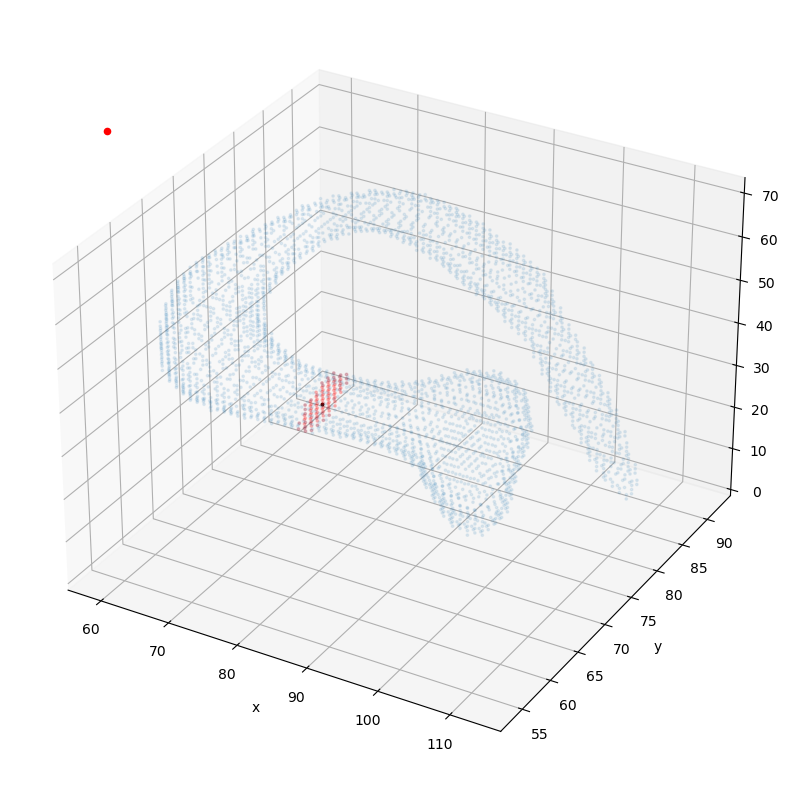

shapes: (160, 130, 72)


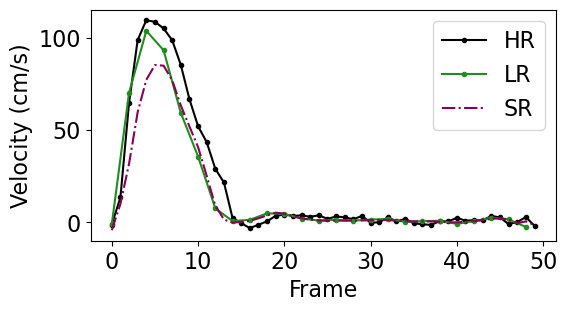

Evaluating descending aorta..
Plot plane flow..
----------------
(array([0, 1]), array([1497447,     153], dtype=int64))
Create boundary mask for 3D data


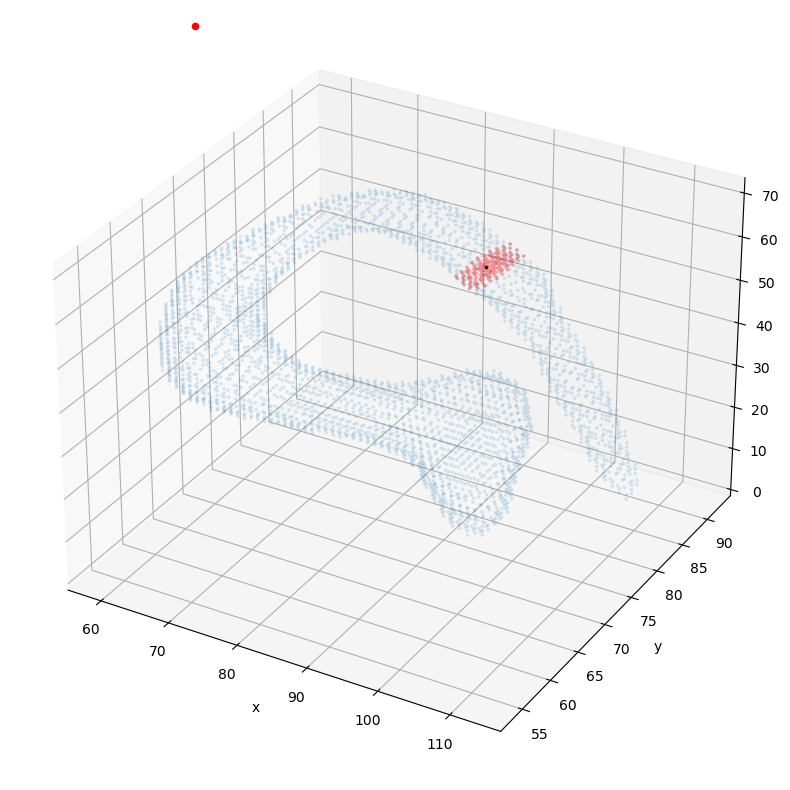

shapes: (160, 130, 72)


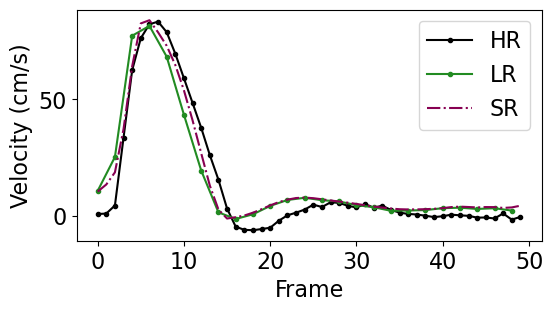

Processing v4...
<KeysViewHDF5 ['mag_u', 'mag_v', 'mag_w', 'mask', 'mask_LV', 'mask_aorta', 'mask_smooth', 'u', 'u_max', 'v', 'v_max', 'w', 'w_max']>
shapes u: (25, 160, 130, 72) (50, 160, 130, 72) (50, 160, 130, 72)
shapes v: (25, 160, 130, 72) (50, 160, 130, 72) (50, 160, 130, 72)
shapes w: (25, 160, 130, 72) (50, 160, 130, 72) (50, 160, 130, 72)
Evaluating ascening aorta..
Plot plane flow..
----------------
(array([0, 1]), array([1497483,     117], dtype=int64))
Create boundary mask for 3D data


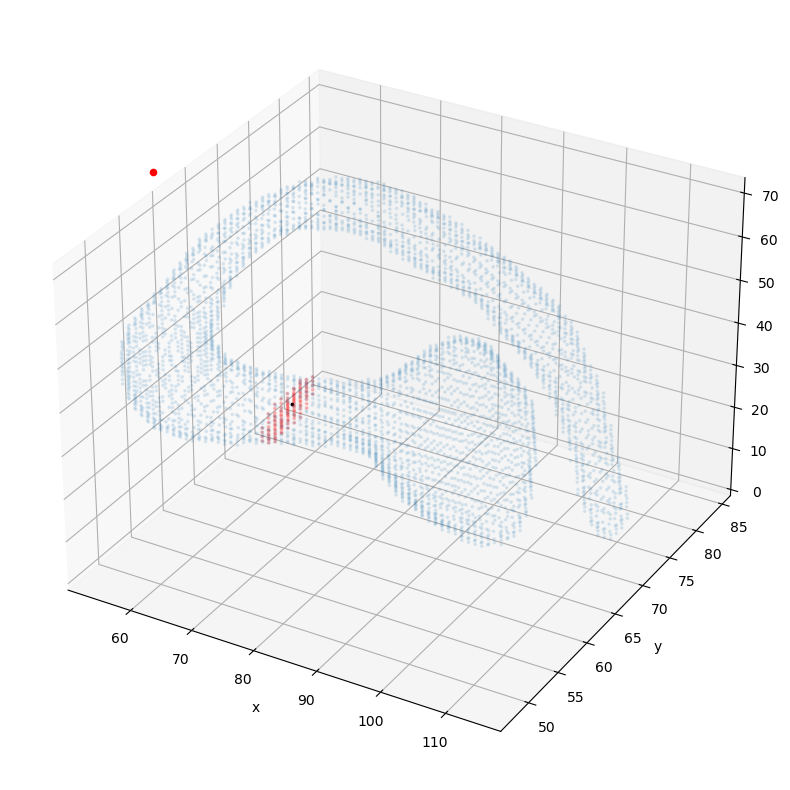

shapes: (160, 130, 72)


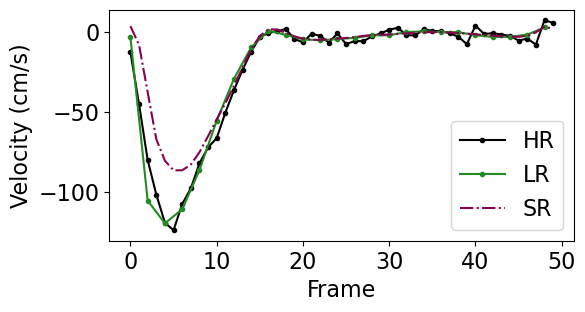

Evaluating descending aorta..
Plot plane flow..
----------------
(array([0, 1]), array([1497460,     140], dtype=int64))
Create boundary mask for 3D data


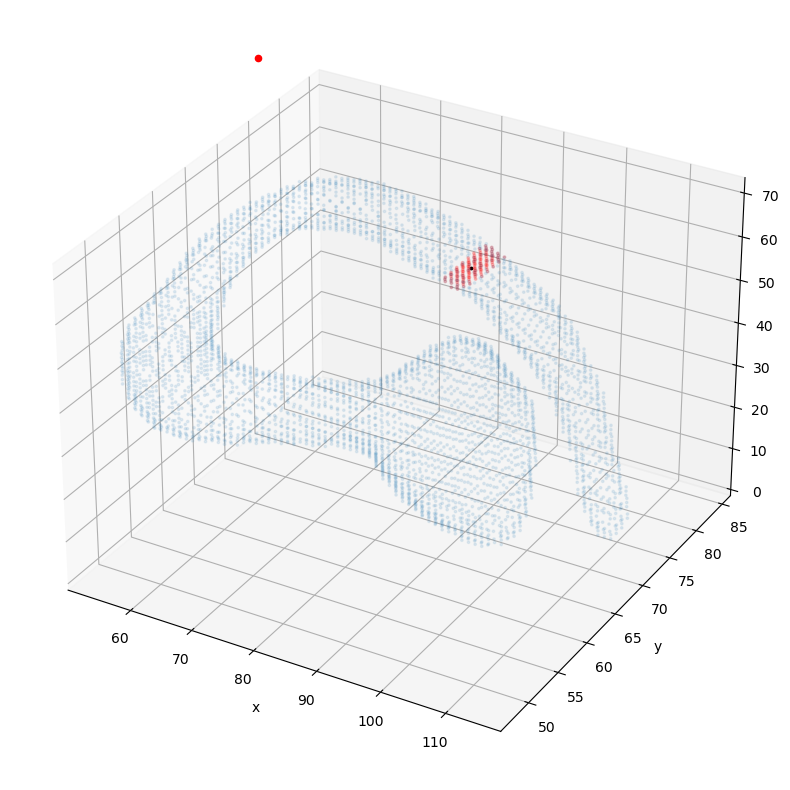

shapes: (160, 130, 72)


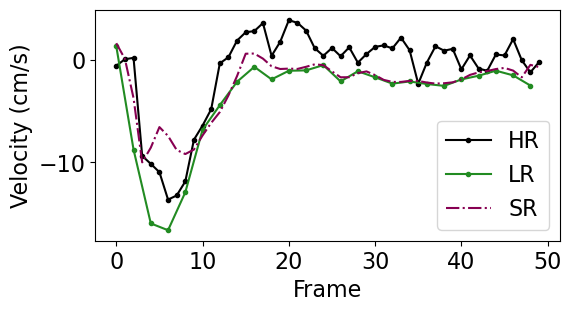

Processing v5...
<KeysViewHDF5 ['mag_u', 'mag_v', 'mag_w', 'mask', 'mask_LV', 'mask_aorta', 'mask_smooth', 'u', 'u_max', 'v', 'v_max', 'w', 'w_max']>
Set default dx
shapes u: (25, 160, 130, 72) (50, 160, 130, 72) (50, 130, 160, 72)
shapes v: (25, 160, 130, 72) (50, 160, 130, 72) (50, 130, 160, 72)
shapes w: (25, 160, 130, 72) (50, 160, 130, 72) (50, 130, 160, 72)
Evaluating ascening aorta..
Plot plane flow..
----------------
(array([0, 1]), array([1497481,     119], dtype=int64))
Create boundary mask for 3D data


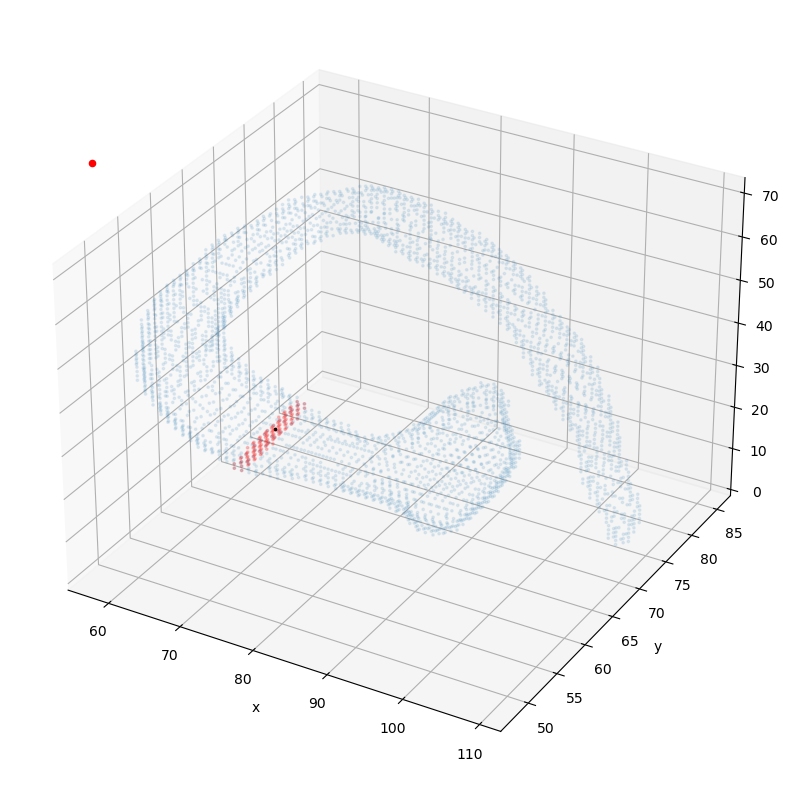

shapes: (160, 130, 72)


AssertionError: Mask and velocity field must have the same shape

In [5]:
# directories
lr_dir = '../../data/paired_invivo'
hr_dir = '../../data/paired_invivo'
sr_dir = '../../results/in_vivo/paired_data'
eval_dir = f'../../results/in_vivo/paired_data/plots/comparison/planeflows'

os.makedirs(eval_dir, exist_ok=True)

volunteers = ['v3', 'v4',  'v5', 'v6', 'v7'] #['v5', 'v6' ]#

volunteer_plane_normal_ascending = {
    'v3_origin': [198.75, 166.096, 90.2740], 
    'v3_normal': [-0.9993, -0.03153, 0.019410], 
    'v4_origin': [182.09, 147.1993, 88.808613], 
    'v4_normal': [-0.98131, -0.176387, 0.076911],
    'v5_origin': [184.8120, 141.065, 82.21268],
    'v5_normal': [-0.92945, -0.07347, 0.3615],
    'v6_origin': [198.75, 165.3485, 85.68],
    'v6_normal': [0.98590, 0.055869, -0.15771],
    'v7_origin': [175.760, 167.830, 84.6532],
    'v7_normal': [-0.9899, -0.11857, 0.07666],
}
#'v5_origin': [184.4055,  137.346, 79.96154939],
# 'v5_normal': [-0.869584,-0.031243,  0.49279],
# 'v6_origin': [163.51468, 179.093, 93.1826],
# 'v6_normal': [-0.084936, -0.9213, 0.3793632],
# 'v5_origin': [137.346, 184.4055, 79.96154939],
# 'v5_normal': [-0.031243, -0.869584, 0.49279],
volunteer_plane_normal_descending = {
    'v3_origin': [212.00, 222.761, 112.845],
    'v3_normal': [0.71023, -0.074448, -0.7000],
    'v4_origin': [202.46253, 201.068, 113.0036],
    'v4_normal': [0.7341784, 0.0059383, -0.67893],
    'v5_origin': [201.3359, 205.441, 116.173],
    'v5_normal': [0.658955, -0.14523, -0.738026],
    'v6_origin': [199.579, 216.9952277, 88.363],
    'v6_normal': [0.710689, -0.151932, -0.68690],
    'v7_origin': [204.60304, 216.851, 92.217],
    'v7_normal': [0.74243, -0.112015, -0.66048],
}

# 'v5_origin': [205.15501, 214.5587, 100.761],
# 'v5_normal': [-0.08946, 0.59683, -0.797359],
# 'v6_origin': [217.1083, 191.9412, 93.8917],
# 'v6_normal': [-0.0733, 0.7228494, -0.6871059],

volunteer_plot_settings = {
    'v3': {
        'order_normal': [2, 1, 0],
        'factor_plane_normal': [1, 1, -1],
        'idxs_nonflow_area_ascending': [np.index_exp[:, 80:, :]],
        'idxs_nonflow_area_descending': [np.index_exp[:, :80, :]],
        'thickness_ascending': 30,
        'thickness_descending': 2,
    }, 
    'v4': {
        'order_normal': [2, 1, 0],
        'factor_plane_normal': [1, 1, 1],
        'idxs_nonflow_area_ascending': [np.index_exp[:, 70:, :]],
        'idxs_nonflow_area_descending': [np.index_exp[:, :70, :]],
        'thickness_ascending': 10,
        'thickness_descending': 2,
    }, 
    'v5': {
        'order_normal': [2, 1, 0],
        'factor_plane_normal': [1, 1, -1],
        'idxs_nonflow_area_ascending': [np.index_exp[:, 65:, :]],
        'idxs_nonflow_area_descending': [np.index_exp[:, :65, :]],
        'thickness_ascending': 2,
        'thickness_descending': 2,
    }, 
    'v6': {
        'order_normal': [2, 1, 0],
        'factor_plane_normal': [1, 1, -1],
        'idxs_nonflow_area_ascending': [np.index_exp[:, 73:, :]],
        'idxs_nonflow_area_descending': [np.index_exp[:, :73, :]],
        'thickness_ascending': 2,
        'thickness_descending': 2,
    }, 
    'v7': {
        'order_normal': [2, 1, 0],
        'factor_plane_normal': [1, 1, 1],
        'idxs_nonflow_area_ascending': [np.index_exp[:, 80:, :]],
        'idxs_nonflow_area_descending': [np.index_exp[:, :80, :]],
        'thickness_ascending': 30,
        'thickness_descending': 2,
    }, 
}

# 'v5': {
#         'order_normal': [2, 1, 0],
#         'factor_plane_normal': [1, 1, 1],
#         'idxs_nonflow_area_ascending': [np.index_exp[65:, :, :]],
#         'idxs_nonflow_area_descending': [np.index_exp[:65, :, :]],
#         'thickness_ascending': 2,
#         'thickness_descending': 2,
#     }, 
#     'v6': {
#         'order_normal': [2, 1, 0],
#         'factor_plane_normal': [1, 1, 1],
#         'idxs_nonflow_area_ascending': [np.index_exp[73:, :, :]],
#         'idxs_nonflow_area_descending': [np.index_exp[:73, :, :]],
#         'thickness_ascending': 2,
#         'thickness_descending': 2,
#     },
for volunteer in volunteers:
    print(f'Processing {volunteer}...')
    lr_filename = f'{volunteer}_wholeheart_25mm_40ms.h5'
    hr_filename = f'{volunteer}_wholeheart_25mm_20ms.h5'
    sr_filename = f'{volunteer}_wholeheart_25mm_40ms/{volunteer}_wholeheart_25mm_40ms_20240709-2057.h5' #_wvu_order

    os.makedirs(eval_dir, exist_ok=True)

    with h5py.File(f'{lr_dir}/{lr_filename}', 'r') as f:
        print(f.keys())
        lr_u = np.array(f['u'])
        lr_v = np.array(f['v'])
        lr_w = np.array(f['w'])#*(-1.0)
        # lr_v = np.array(f['u'])
        # lr_w = np.array(f['v'])
        # lr_u = np.array(f['w'])
        mask = np.array(f['mask_smooth'])
        mask_aorta = np.array(f['mask_aorta'])
        mask_lv = np.array(f['mask_LV'])

    with h5py.File(f'{hr_dir}/{hr_filename}', 'r') as f:
        hr_u = np.array(f['u'])
        hr_v = np.array(f['v'])
        hr_w = np.array(f['w'])#*(-1.0)
        # lr_v = np.array(f['u'])
        # lr_w = np.array(f['v'])
        # lr_u = np.array(f['w'])
        if 'dx' in f.keys():
            dx = np.array(f['dx'])
        else:
            print('Set default dx')
            dx = 2.5

    with h5py.File(f'{sr_dir}/{sr_filename}', 'r') as f:
        sr_u = np.array(f['u_combined'])
        sr_v = np.array(f['v_combined'])
        sr_w = np.array(f['w_combined'])
    
    T_lr = lr_u.shape[0]
    T_hr = hr_u.shape[0]
    
    print('shapes u:', lr_u.shape, hr_u.shape, sr_u.shape)
    print('shapes v:', lr_v.shape, hr_v.shape, sr_v.shape)
    print('shapes w:', lr_w.shape, hr_w.shape, sr_w.shape)

    plane_normal_ascending = np.array(volunteer_plane_normal_ascending[f'{volunteer}_normal'])
    cp_plane_ascending = np.array(volunteer_plane_normal_ascending[f'{volunteer}_origin'])/dx

    plane_normal_descending = np.array(volunteer_plane_normal_descending[f'{volunteer}_normal'])
    cp_plane_descending = np.array(volunteer_plane_normal_descending[f'{volunteer}_origin'])/dx

    print('Evaluating ascening aorta..')
    # plot ascending aorta
    plot_plane_flows(hr_u, hr_v, hr_w, lr_u, lr_v, lr_w, sr_u, sr_v, sr_w, 
                    cp_plane_ascending, plane_normal_ascending, volunteer_plot_settings[volunteer]['idxs_nonflow_area_ascending'], order_normal = volunteer_plot_settings[volunteer]['order_normal'], 
                    thickness=volunteer_plot_settings[volunteer]['thickness_ascending'], factor_plane_normal = volunteer_plot_settings[volunteer]['factor_plane_normal'], 
                    save_as = f'{eval_dir}/{volunteer}_ascending_aorta.svg')

    # plot descending aorta
    print('Evaluating descending aorta..')
    plot_plane_flows(hr_u, hr_v, hr_w, lr_u, lr_v, lr_w, sr_u, sr_v, sr_w,
                    cp_plane_descending, plane_normal_descending, volunteer_plot_settings[volunteer]['idxs_nonflow_area_descending'], order_normal = volunteer_plot_settings[volunteer]['order_normal'],  
                    thickness=volunteer_plot_settings[volunteer]['thickness_descending'], factor_plane_normal = volunteer_plot_settings[volunteer]['factor_plane_normal'], 
                    save_as = f'{eval_dir}/{volunteer}_descending_aorta.svg')

### Evaluation table - comparison between volunteers

In [ ]:

# directories
lr_dir = '../../data/paired_invivo'
hr_dir = '../../data/paired_invivo'
sr_dir = '../../results/in_vivo/paired_data'
eval_dir = f'../../results/in_vivo/paired_data/plots/comparison'

volunteers = ['v3', 'v4', 'v5', 'v6', 'v7'] 

results_aorta_lv = {}
results_aorta = {}
results_lv = {}

for volunteer in volunteers:

    lr_filename = f'{volunteer}_wholeheart_25mm_40ms.h5'
    hr_filename = f'{volunteer}_wholeheart_25mm_20ms.h5'
    sr_filename = f'{volunteer}_wholeheart_25mm_40ms/{volunteer}_wholeheart_25mm_40ms_20240709-2057.h5'

    os.makedirs(eval_dir, exist_ok=True)

    with h5py.File(f'{lr_dir}/{lr_filename}', 'r') as f:
        lr_u = np.array(f['u'])
        lr_v = np.array(f['v'])
        lr_w = np.array(f['w'])
        mask = np.array(f['mask'])
        mask_aorta = np.array(f['mask_aorta'])
        mask_lv = np.array(f['mask_LV'])

    with h5py.File(f'{hr_dir}/{hr_filename}', 'r') as f:
        hr_u = np.array(f['u'])
        hr_v = np.array(f['v'])
        hr_w = np.array(f['w'])

    with h5py.File(f'{sr_dir}/{sr_filename}', 'r') as f:
        sr_u = np.array(f['u_combined'])
        sr_v = np.array(f['v_combined'])
        sr_w = np.array(f['w_combined'])

    T_lr = lr_u.shape[0]
    T_hr = hr_u.shape[0]


    #------ whole heart evaluation (aorta + lv) ------
    # calculate rmse 
    rmse_u = np.sqrt(np.mean((hr_u - sr_u)**2, axis=(1, 2, 3), where=mask.astype(bool)))
    rmse_v = np.sqrt(np.mean((hr_v - sr_v)**2, axis=(1, 2, 3), where=mask.astype(bool)))
    rmse_w = np.sqrt(np.mean((hr_w - sr_w)**2, axis=(1, 2, 3), where=mask.astype(bool)))

    # calculate k and r2 values for each direction over time

    k_u_srhr, r2_u_srhr = calculate_k_R2_timeseries(sr_u, hr_u, np.repeat(mask[np.newaxis, ...], T_hr, axis=0))
    k_v_srhr, r2_v_srhr = calculate_k_R2_timeseries(sr_v, hr_v, np.repeat(mask[np.newaxis, ...], T_hr, axis=0))
    k_w_srhr, r2_w_srhr = calculate_k_R2_timeseries(sr_w, hr_w, np.repeat(mask[np.newaxis, ...], T_hr, axis=0))

    results_aorta_lv_volunteer = {}
    results_aorta_lv_volunteer['Volunteer'] = volunteer
    results_aorta_lv_volunteer['RMSE_u'] = rmse_u
    results_aorta_lv_volunteer['RMSE_v'] = rmse_v
    results_aorta_lv_volunteer['RMSE_w'] = rmse_w
    results_aorta_lv_volunteer['k_u'] = k_u_srhr
    results_aorta_lv_volunteer['k_v'] = k_v_srhr
    results_aorta_lv_volunteer['k_w'] = k_w_srhr
    results_aorta_lv_volunteer['r2_u'] = r2_u_srhr
    results_aorta_lv_volunteer['r2_v'] = r2_v_srhr
    results_aorta_lv_volunteer['r2_w'] = r2_w_srhr


    #------ aorta evaluation ------
    # calculate rmse
    rmse_u_aorta = np.sqrt(np.mean((hr_u - sr_u)**2, axis=(1, 2, 3), where=mask_aorta.astype(bool)))
    rmse_v_aorta = np.sqrt(np.mean((hr_v - sr_v)**2, axis=(1, 2, 3), where=mask_aorta.astype(bool)))
    rmse_w_aorta = np.sqrt(np.mean((hr_w - sr_w)**2, axis=(1, 2, 3), where=mask_aorta.astype(bool)))

    # calculate k and r2 values for each direction over time

    k_u_srhr_aorta, r2_u_srhr_aorta = calculate_k_R2_timeseries(sr_u, hr_u, np.repeat(mask_aorta[np.newaxis, ...], T_hr, axis=0))
    k_v_srhr_aorta, r2_v_srhr_aorta = calculate_k_R2_timeseries(sr_v, hr_v, np.repeat(mask_aorta[np.newaxis, ...], T_hr, axis=0))
    k_w_srhr_aorta, r2_w_srhr_aorta = calculate_k_R2_timeseries(sr_w, hr_w, np.repeat(mask_aorta[np.newaxis, ...], T_hr, axis=0))

    results_aorta_volunteer = {}
    results_aorta_volunteer['Volunteer'] = volunteer
    results_aorta_volunteer['RMSE_u'] = rmse_u_aorta
    results_aorta_volunteer['RMSE_v'] = rmse_v_aorta
    results_aorta_volunteer['RMSE_w'] = rmse_w_aorta
    results_aorta_volunteer['k_u'] = k_u_srhr_aorta
    results_aorta_volunteer['k_v'] = k_v_srhr_aorta
    results_aorta_volunteer['k_w'] = k_w_srhr_aorta
    results_aorta_volunteer['r2_u'] = r2_u_srhr_aorta
    results_aorta_volunteer['r2_v'] = r2_v_srhr_aorta
    results_aorta_volunteer['r2_w'] = r2_w_srhr_aorta

    #------ left ventricle evaluation ------
    # calculate rmse
    rmse_u_lv = np.sqrt(np.mean((hr_u - sr_u)**2, axis=(1, 2, 3), where=mask_lv.astype(bool)))
    rmse_v_lv = np.sqrt(np.mean((hr_v - sr_v)**2, axis=(1, 2, 3), where=mask_lv.astype(bool)))
    rmse_w_lv = np.sqrt(np.mean((hr_w - sr_w)**2, axis=(1, 2, 3), where=mask_lv.astype(bool)))

    # calculate k and r2 values for each direction over time
    
    k_u_srhr_lv, r2_u_srhr_lv = calculate_k_R2_timeseries(sr_u, hr_u, np.repeat(mask_lv[np.newaxis, ...], T_hr, axis=0))
    k_v_srhr_lv, r2_v_srhr_lv = calculate_k_R2_timeseries(sr_v, hr_v, np.repeat(mask_lv[np.newaxis, ...], T_hr, axis=0))
    k_w_srhr_lv, r2_w_srhr_lv = calculate_k_R2_timeseries(sr_w, hr_w, np.repeat(mask_lv[np.newaxis, ...], T_hr, axis=0))

    results_lv_volunteer = {}
    results_lv_volunteer['Volunteer'] = volunteer
    results_lv_volunteer['RMSE_u'] = rmse_u_lv
    results_lv_volunteer['RMSE_v'] = rmse_v_lv
    results_lv_volunteer['RMSE_w'] = rmse_w_lv
    results_lv_volunteer['k_u'] = k_u_srhr_lv
    results_lv_volunteer['k_v'] = k_v_srhr_lv
    results_lv_volunteer['k_w'] = k_w_srhr_lv
    results_lv_volunteer['r2_u'] = r2_u_srhr_lv
    results_lv_volunteer['r2_v'] = r2_v_srhr_lv
    results_lv_volunteer['r2_w'] = r2_w_srhr_lv

    # save results in dictionary
    results_aorta_lv[volunteer] = results_aorta_lv_volunteer
    results_aorta[volunteer] = results_aorta_volunteer
    results_lv[volunteer] = results_lv_volunteer

# results in df

# plot results
plt.figure(figsize=(15, 10))

# RMSE
plt.subplot(2, 3, 1)
for volunteer in volunteers:
    plt.plot(results_aorta_lv[volunteer]['RMSE_u'], label=volunteer)
plt.xlabel('Frame', fontsize=12)
plt.ylabel('RMSE u', fontsize=12)
plt.legend(fontsize=10)

plt.subplot(2, 3, 2)
for volunteer in volunteers:
    plt.plot(results_aorta_lv[volunteer]['RMSE_v'], label=volunteer)
plt.xlabel('Frame', fontsize=12)
plt.ylabel('RMSE v', fontsize=12)
plt.legend(fontsize=10)

plt.subplot(2, 3, 3)
for volunteer in volunteers:
    plt.plot(results_aorta_lv[volunteer]['RMSE_w'], label=volunteer)
plt.xlabel('Frame', fontsize=12)
plt.ylabel('RMSE w', fontsize=12)
plt.legend(fontsize=10)

# k
plt.subplot(2, 3, 4)
for volunteer in volunteers:
    plt.plot(results_aorta_lv[volunteer]['k_u'], label=volunteer)
plt.xlabel('Frame', fontsize=12)
plt.ylabel('k u', fontsize=12)
plt.legend(fontsize=10)

plt.subplot(2, 3, 5)
for volunteer in volunteers:
    plt.plot(results_aorta_lv[volunteer]['k_v'], label=volunteer)
plt.xlabel('Frame', fontsize=12)
plt.ylabel('k v', fontsize=12)
plt.legend(fontsize=10)

plt.subplot(2, 3, 6)
for volunteer in volunteers:
    plt.plot(results_aorta_lv[volunteer]['k_w'], label=volunteer)
plt.xlabel('Frame', fontsize=12)
plt.ylabel('k w', fontsize=12)
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

# r2
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
for volunteer in volunteers:
    plt.plot(results_aorta_lv[volunteer]['r2_u'], label=volunteer)
plt.xlabel('Frame', fontsize=12)
plt.ylabel('r2 u', fontsize=12)
plt.legend(fontsize=10)

plt.subplot(1, 3, 2)
for volunteer in volunteers:
    plt.plot(results_aorta_lv[volunteer]['r2_v'], label=volunteer)
plt.xlabel('Frame', fontsize=12)
plt.ylabel('r2 v', fontsize=12)
plt.legend(fontsize=10)

plt.subplot(1, 3, 3)
for volunteer in volunteers:
    plt.plot(results_aorta_lv[volunteer]['r2_w'], label=volunteer)
plt.xlabel('Frame', fontsize=12)
plt.ylabel('r2 w', fontsize=12)
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()


# now create a dataframe with the results, by taking the mean over all timesteps
results_aorta_lv_mean = defaultdict(list)
results_aorta_mean = defaultdict(list)
results_lv_mean = defaultdict(list)

for volunteer in volunteers:
    for key in results_aorta_lv[volunteer].keys():
        if key != 'Volunteer':
            results_aorta_lv_mean[key].append(np.mean(results_aorta_lv[volunteer][key]))
            results_aorta_mean[key].append(np.mean(results_aorta[volunteer][key]))
            results_lv_mean[key].append(np.mean(results_lv[volunteer][key]))
        else:
            results_aorta_lv_mean[key].append(volunteer)
            results_aorta_mean[key].append(volunteer)
            results_lv_mean[key].append(volunteer)

# to dataframe
df_aorta_lv = pd.DataFrame(results_aorta_lv_mean)
df_aorta = pd.DataFrame(results_aorta_mean)
df_lv = pd.DataFrame(results_lv_mean)

# save results
df_aorta_lv.to_csv(f'{eval_dir}/results_aorta_lv.csv')
df_aorta.to_csv(f'{eval_dir}/results_aorta.csv')
df_lv.to_csv(f'{eval_dir}/results_lv.csv')

# display results
print('Results aorta and left ventricle:')
display(df_aorta_lv)
print('Results aorta:')
display(df_aorta)
print('Results left ventricle:')
display(df_lv)



In [ ]:
# directories
lr_dir = '../../data/paired_invivo'
hr_dir = '../../data/paired_invivo'

volunteers = ['v3', 'v4',  'v5', 'v6', 'v7'] 



for volunteer in volunteers:

    lr_filename = f'{volunteer}_wholeheart_25mm_40ms.h5'
    hr_filename = f'{volunteer}_wholeheart_25mm_20ms.h5'

    print(f'Processing {volunteer}...')
    
    with h5py.File(f'{lr_dir}/{lr_filename}', 'r') as f:
        lr_u = np.array(f['u'])
        mask = np.array(f['mask'])
    
    with h5py.File(f'{hr_dir}/{hr_filename}', 'r') as f:
        hr_u = np.array(f['u'])

    print(f'Shapes: HR: {hr_u.shape}, LR: {lr_u.shape}, Mask: {mask.shape}')

In [ ]:
# now make tabular from specific frames

# define peak systole and diastole frames for each volunteer 
t_frames_diastole_systole = {'v3': [9, 21], 'v4':[11,23], 'v5': [9, 21], 'v6': [11, 25], 'v7':[9, 25]}

df_aorta_lv_frames = pd.DataFrame()
df_aorta_peak_systole = pd.DataFrame()
df_aorta_peak_diastole = pd.DataFrame()
df_lv_peak_systole = pd.DataFrame()
df_lv_peak_diastole = pd.DataFrame()

for volunteer in volunteers:
    t_sys = t_frames_diastole_systole[volunteer][0]
    t_dia = t_frames_diastole_systole[volunteer][1]
    df_aorta_lv_frames = pd.concat([df_aorta_lv_frames, pd.DataFrame(results_aorta_lv[volunteer]).iloc[t_sys, :].to_frame().T])
    df_aorta_lv_frames = pd.concat([df_aorta_lv_frames, pd.DataFrame(results_aorta_lv[volunteer]).iloc[t_dia, :].to_frame().T])
    df_aorta_peak_systole = pd.concat([df_aorta_peak_systole, pd.DataFrame(results_aorta[volunteer]).iloc[t_sys, :].to_frame().T])
    df_aorta_peak_diastole = pd.concat([df_aorta_peak_diastole, pd.DataFrame(results_aorta[volunteer]).iloc[t_dia, :].to_frame().T])
    df_lv_peak_systole = pd.concat([df_lv_peak_systole, pd.DataFrame(results_lv[volunteer]).iloc[t_sys, :].to_frame().T])
    df_lv_peak_diastole = pd.concat([df_lv_peak_diastole, pd.DataFrame(results_lv[volunteer]).iloc[t_dia, :].to_frame().T])

# put in one dataframe
df_aorta_lv_frames['Cardiac Phase'] = ['Systole', 'Diastole'] * len(volunteers)
df_aorta_peak_systole['Cardiac Phase'] = ['Systole'] * len(volunteers)
df_aorta_peak_diastole['Cardiac Phase'] = ['Diastole'] * len(volunteers)
df_lv_peak_systole['Cardiac Phase'] = ['Systole'] * len(volunteers)
df_lv_peak_diastole['Cardiac Phase'] = ['Diastole'] * len(volunteers)
# add also which frame number has been evaluated
# for volunteer in volunteers:
#     df_aorta_lv_frames['Frame Number'] = [t_frames_diastole_systole[volunteer][0], t_frames_diastole_systole[volunteer][1]] * len(volunteers)
#     df_aorta_peak_systole['Frame Number'] = [t_frames_diastole_systole[volunteer][0]] * len(volunteers)
#     df_aorta_peak_diastole['Frame Number'] = [t_frames_diastole_systole[volunteer][1]] * len(volunteers)
#     df_lv_peak_systole['Frame Number'] = [t_frames_diastole_systole[volunteer][1]] * len(volunteers)

# df_aorta_lv_frames['Region'] = ['Aorta', 'LV'] * len(volunteers) 
df_aorta_peak_systole['Region'] = ['Aorta'] * len(volunteers)
df_aorta_peak_diastole['Region'] = ['Aorta'] * len(volunteers)
df_lv_peak_systole['Region'] = ['LV'] * len(volunteers)
df_lv_peak_diastole['Region'] = ['LV'] * len(volunteers)


df_aorta_lv_frames = df_aorta_lv_frames.reset_index(drop=True)
df_aorta_peak_systole = df_aorta_peak_systole.reset_index(drop=True)
df_aorta_peak_diastole = df_aorta_peak_diastole.reset_index(drop=True)
df_lv_peak_systole = df_lv_peak_systole.reset_index(drop=True)
df_lv_peak_diastole = df_lv_peak_diastole.reset_index(drop=True)

display(df_aorta_lv_frames)



# now make a table with aorta peak systole and lv peak diastole
# df_peak_systole_diastole = pd.concat([df_aorta_peak_systole.reset_index(drop=True), df_lv_peak_diastole.reset_index(drop=True)], axis=1)
df_peak_systole_diastole = pd.concat([df_aorta_peak_systole, df_lv_peak_diastole], axis=0)
# Scale RMSE columns by 1/100
rmse_columns = [col for col in df_peak_systole_diastole.columns if 'RMSE' in col]
df_peak_systole_diastole[rmse_columns] = df_peak_systole_diastole[rmse_columns] / 100
display(df_peak_systole_diastole)

#print in latex
print(df_peak_systole_diastole.to_latex(index=False, float_format="%.2f"))

In [ ]:
rmse_columns
k_columns = [col for col in df_peak_systole_diastole.columns if 'k' in col]
r2_columns = [col for col in df_peak_systole_diastole.columns if 'r2' in col]
#  calculate mean over RMSE, k, and R2
systole_diastole_mean_rmse = df_peak_systole_diastole.groupby('Region')[rmse_columns].mean()
systole_diastole_mean_k = df_peak_systole_diastole.groupby('Region')[k_columns].mean()
systole_diastole_mean_r2 = df_peak_systole_diastole.groupby('Region')[r2_columns].mean()

print(systole_diastole_mean_rmse.mean(axis = 1))
print(systole_diastole_mean_k.mean(axis = 1))
print(systole_diastole_mean_r2.mean(axis = 1))

Interpolation evaluation 

In [ ]:


results_all_volunteers = {}

volunteers= ['v3','v4', 'v5', 'v6', 'v7']

for volunteer in volunteers:
    # Load HR and LR data
    with h5py.File(f'{hr_dir}/{volunteer}_wholeheart_25mm_20ms.h5', 'r') as f:
        hr_u = np.array(f['u'])
        hr_v = np.array(f['v'])
        hr_w = np.array(f['w'])
        mask = np.array(f['mask'])

    with h5py.File(f'{lr_dir}/{volunteer}_wholeheart_25mm_40ms.h5', 'r') as f:
        lr_u = np.array(f['u'])
        lr_v = np.array(f['v'])
        lr_w = np.array(f['w'])

    # Linear interpolation
    lr_u_linear_interp = temporal_linear_interpolation_np(lr_u, hr_u.shape)
    lr_v_linear_interp = temporal_linear_interpolation_np(lr_v, hr_v.shape)
    lr_w_linear_interp = temporal_linear_interpolation_np(lr_w, hr_w.shape)

    # Sinc interpolation
    hr_range = np.linspace(0, 1, hr_u.shape[0])
    lr_range = hr_range[::2]  # Downsample to match evaluation points
    lr_u_sinc_interp = temporal_sinc_interpolation_ndarray(lr_u, lr_range, hr_range)
    lr_v_sinc_interp = temporal_sinc_interpolation_ndarray(lr_v, lr_range, hr_range)
    lr_w_sinc_interp = temporal_sinc_interpolation_ndarray(lr_w, lr_range, hr_range)

    # Calculate results for linear interpolation
    rmse_u_linear = np.sqrt(np.mean((hr_u - lr_u_linear_interp)**2, axis=(1, 2, 3), where=mask.astype(bool)))
    rmse_v_linear = np.sqrt(np.mean((hr_v - lr_v_linear_interp)**2, axis=(1, 2, 3), where=mask.astype(bool)))
    rmse_w_linear = np.sqrt(np.mean((hr_w - lr_w_linear_interp)**2, axis=(1, 2, 3), where=mask.astype(bool)))
    k_u_linear, r2_u_linear = calculate_k_R2_timeseries(lr_u_linear_interp, hr_u, np.repeat(mask[np.newaxis, ...], T_hr, axis=0))
    k_v_linear, r2_v_linear = calculate_k_R2_timeseries(lr_v_linear_interp, hr_v, np.repeat(mask[np.newaxis, ...], T_hr, axis=0))
    k_w_linear, r2_w_linear = calculate_k_R2_timeseries(lr_w_linear_interp, hr_w, np.repeat(mask[np.newaxis, ...], T_hr, axis=0))

    # Calculate results for sinc interpolation
    rmse_u_sinc = np.sqrt(np.mean((hr_u - lr_u_sinc_interp)**2, axis=(1, 2, 3), where=mask.astype(bool)))
    rmse_v_sinc = np.sqrt(np.mean((hr_v - lr_v_sinc_interp)**2, axis=(1, 2, 3), where=mask.astype(bool)))
    rmse_w_sinc = np.sqrt(np.mean((hr_w - lr_w_sinc_interp)**2, axis=(1, 2, 3), where=mask.astype(bool)))
    k_u_sinc, r2_u_sinc = calculate_k_R2_timeseries(lr_u_sinc_interp, hr_u, np.repeat(mask[np.newaxis, ...], T_hr, axis=0))
    k_v_sinc, r2_v_sinc = calculate_k_R2_timeseries(lr_v_sinc_interp, hr_v, np.repeat(mask[np.newaxis, ...], T_hr, axis=0))
    k_w_sinc, r2_w_sinc = calculate_k_R2_timeseries(lr_w_sinc_interp, hr_w, np.repeat(mask[np.newaxis, ...], T_hr, axis=0))

    # Store results for linear interpolation
    results_linear = {
        'Volunteer': f'{volunteer}_linear',
        'RMSE_u': rmse_u_linear,
        'RMSE_v': rmse_v_linear,
        'RMSE_w': rmse_w_linear,
        'k_u': k_u_linear,
        'k_v': k_v_linear,
        'k_w': k_w_linear,
        'r2_u': r2_u_linear,
        'r2_v': r2_v_linear,
        'r2_w': r2_w_linear
    }

    # Store results for sinc interpolation
    results_sinc = {
        'Volunteer': f'{volunteer}_sinc',
        'RMSE_u': rmse_u_sinc,
        'RMSE_v': rmse_v_sinc,
        'RMSE_w': rmse_w_sinc,
        'k_u': k_u_sinc,
        'k_v': k_v_sinc,
        'k_w': k_w_sinc,
        'r2_u': r2_u_sinc,
        'r2_v': r2_v_sinc,
        'r2_w': r2_w_sinc
    }

    # Combine the results for each volunteer
    results_all_volunteers[f'{volunteer}_linear'] = results_linear
    results_all_volunteers[f'{volunteer}_sinc'] = results_sinc

# Convert results to a DataFrame
results_table_interp = pd.DataFrame.from_dict(results_all_volunteers, orient='index')
# Initialize an empty dictionary for the averages (means)
results_table_avg_interp = results_table_interp.copy()

for index, row in results_table_interp.iterrows():
    for colname in results_table_interp.columns:
        if colname != 'Volunteer':
            
            results_table_avg_interp.loc[index, colname] = np.mean(row[colname])


# Display the original table (with lists of values) and the table with averages
display(results_table_interp)
display(results_table_avg_interp)

# save avg table to csv
results_table_avg_interp.to_csv(f'{eval_dir}/results_table_avg.csv')


In [ ]:
# fuse to one larger table

df_whole_eval = df_aorta_lv.copy()

mean_values = df_whole_eval.drop(columns=['Volunteer']).mean()

# Add the mean row to the DataFrame
df_whole_eval.loc['mean sr'] = mean_values
display(df_whole_eval)
# iterate over all volunteers and add the results to the dataframe

linear_results = results_table_avg[results_table_avg['Volunteer'].str.contains('_linear')]
sinc_results   = results_table_avg[results_table_avg['Volunteer'].str.contains('_sinc')]

mean_linear_values = linear_results.drop(columns=['Volunteer']).mean()
mean_sinc_values = sinc_results.drop(columns=['Volunteer']).mean()


df_whole_eval.loc['mean linear'] = mean_linear_values
df_whole_eval.loc['mean sinc'] = mean_sinc_values

display(df_whole_eval)

#to csv
df_whole_eval.to_csv(f'{eval_dir}/results_whole_eval.csv')

#print to latex
print(df_whole_eval.to_latex(float_format="%.2f"))